In [1]:
import pandas as pd

df_param_all=pd.read_csv('Settings.csv')
df_param_0_0=df_param_all[df_param_all['program']=='0-0_pre_setting'].iloc[:,1:].set_index('param_name')
df_param_0_6=df_param_all[df_param_all['program']=='0-6_crop_image'].iloc[:,1:].set_index('param_name')
df_param_1_1=df_param_all[df_param_all['program']=='1-1_center_classifier'].iloc[:,1:].set_index('param_name')

In [2]:
#1-1 param
im_width=float(df_param_0_0.at['im_width','value']) #全体画像サイズ,これの100倍 pix
im_height=float(df_param_0_0.at['im_height','value'])
dpi=float(df_param_0_0.at['dpi','value'])
img_width=int(im_width*dpi)
img_height=int(im_height*dpi)
print('[IMAGE] ',f'im_width:{im_width}, im_height:{im_height}, dpi:{dpi}')

[IMAGE]  im_width:10.24, im_height:5.12, dpi:100.0


In [3]:
#2 param
window_size=int(df_param_0_6.at['window_size','value']) 
window_slide=int(df_param_0_6.at['window_slide','value']) 
window_width_num=(img_width-window_size)//window_slide+5
window_height_num=(img_height-window_size)//window_slide+5
#window_num=window_width_num*window_height_num
window_num=1352
print('[WINDOW] ',f'window_size:{window_size}, window_slide:{window_slide}')
print(f'window_width_num:{window_width_num}, window_num:{window_num}')

[WINDOW]  window_size:40, window_slide:20
window_width_num:54, window_num:1352


In [4]:
#3 param
#resize_window_size=int(df_param_1_1.at['resize_window_size','value'])#固定でいい気がする
resize_window_size=48
N_EPOCHS=int(df_param_1_1.at['N_EPOCHS','value'])
#MINI_SET_NUM=int(df_param_1_1.at['MINI_SET_NUM','value'])#ミニセット1つ当たりの元画像枚数
batch_size_limit=int(df_param_1_1.at['batch_size_limit','value'])
MINI_SET_NUM=500
print('[BATCH] ',f'resize_window_size:{resize_window_size}, N_EPOCHS:{N_EPOCHS}, MINI_SET_NUM:{MINI_SET_NUM}, batch_size_limit:{batch_size_limit}')

[BATCH]  resize_window_size:48, N_EPOCHS:100, MINI_SET_NUM:500, batch_size_limit:2000


In [5]:
dir_all='output_image'
dir_crop_img=dir_all+'/0-6_crop_image'
dir_crop_diff=dir_all+'/0-6_crop_diff'
dir_b_cen=dir_all+'/0-6_crop_classifier'
dir_pred_classified=dir_all+'/2-1_pred_classified'

In [6]:
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import pandas as pd

In [7]:
#batch_sizeを丁度良い数に決める．
if window_num<=batch_size_limit:
    batch_size=(batch_size_limit//window_num)*window_num
elif window_num<=batch_size_limit*1.2:
    batch_size=window_num
else:
    if window_num%2==0 and window_num/2<batch_size_limit*1.2:
        batch_size=window_num//2
    elif window_num%3==0 and window_num/3<batch_size_limit*1.2:
        batch_size=window_num//3
    elif window_num%4==0 and window_num/4<batch_size_limit*1.2:
        batch_size=window_num//4
    elif window_num%5==0 and window_num/5<batch_size_limit*1.2:
        batch_size=window_num//5
    elif window_num%6==0 and window_num/6<batch_size_limit*1.2:
        batch_size=window_num//6
    elif window_num%7==0 and window_num/7<batch_size_limit*1.2:
        batch_size=window_num//7
    else:
        batch_size=1000
print('window_num:',window_num,',   batch_size:',batch_size)

window_num: 1352 ,   batch_size: 1352


In [8]:
#枚数取得
import glob

l=glob.glob(dir_crop_img+'/train/*')
#train_num=len(l)
train_num=500

l=glob.glob(dir_crop_img+'/val/*')
#val_num=len(l)
val_num=50

l=glob.glob(dir_crop_img+'/test/*')
test_num=len(l)
print('train:',train_num,',  val:',val_num,',  test:',test_num)

train: 500 ,  val: 50 ,  test: 0


In [9]:
import os
def make_dir(dir_loc,dir_name):
    save_dir=dir_loc+'/'+dir_name
    try:os.mkdir(save_dir)
    except:pass

In [10]:
#ディレクトリ作成

dir_list=['train','val','test']
for data in dir_list:
    make_dir(dir_pred_classified,data)

In [11]:
#imgの変換
import cv2
def image_read_translator(file):
    #read
    img= np.array(Image.open(file))
    #resize
    img_resize=cv2.resize(img, dsize=(resize_window_size, resize_window_size))
    #gray_scale
    gray=cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    #rescale
    norm_img=np.array(gray).astype("float32") / 255.0
    return norm_img

In [12]:
#train

#crop_image読み込み,dir_nameのみ
train_images=[]
for k in range(train_num):
    dir_train_img=dir_crop_img+'/train/train_image_'+str(k).zfill(6)+'/*'
    data_train=glob.glob(dir_train_img)

    for i in data_train:
        train_images.append(i)

#crop_image読み込み,dir_nameのみ
train_diffs=[]
for k in range(train_num):
    dir_train_diff=dir_crop_diff+'/train/train_image_'+str(k).zfill(6)+'/*'
    data_train=glob.glob(dir_train_diff)

    for i in data_train:
        train_diffs.append(i)

In [13]:
#val
#crop_img,crop_diff読み込み

#image変換しとく
val_inputs=[]
for k in range(val_num):
    #image
    dir_val_img=dir_crop_img+'/val/val_image_'+str(k).zfill(6)+'/*'
    data_val_img=glob.glob(dir_val_img)
    #diff
    dir_val_diff=dir_crop_diff+'/val/val_image_'+str(k).zfill(6)+'/*'
    data_val_diff=glob.glob(dir_val_diff)
    
    for i in range(len(data_val_img)):
        img_i=image_read_translator(data_val_img[i])
        diff_i=image_read_translator(data_val_diff[i])
        val_input_i=np.stack([img_i,diff_i],axis=2)
        val_inputs.append(val_input_i)
#reshape        
val_inputs=np.array(val_inputs).reshape(val_num*window_num, resize_window_size, resize_window_size, 2)

In [14]:
#test(ignore)
#crop_img,crop_diff読み込み

test_inputs=[]
if test_num>0:
    #image変換しとく
    for k in range(test_num):
        #image
        dir_test_img=dir_crop_img+'/test/test_image_'+str(k).zfill(6)+'/*'
        data_test_img=glob.glob(dir_test_img)
        #diff
        dir_test_diff=dir_crop_diff+'/test/test_image_'+str(k).zfill(6)+'/*'
        data_test_diff=glob.glob(dir_test_diff)

        for i in range(len(data_test_img)):
            img_i=image_read_translator(data_test_img[i])
            diff_i=image_read_translator(data_test_diff[i])
            test_input_i=np.stack([img_i,diff_i],axis=2)
            test_inputs.append(test_input_i)
    #reshape        
    test_inputs=np.array(test_inputs).reshape(val_num*window_num, resize_window_size, resize_window_size, 2)

In [15]:
#labels

#data_train
train_labels=[]
for k in range(train_num):
    dir_train_labels=dir_b_cen+'/train/train_image_'+str(k).zfill(6)+'.npy'
    #train_labels=train_labels+np.load(dir_train_labels)
    #print(np.load(dir_train_labels))
    train_labels=np.concatenate([train_labels, np.load(dir_train_labels)], 0)


#data_val
val_labels=[]
for k in range(val_num):
    dir_val_labels=dir_b_cen+'/val/val_image_'+str(k).zfill(6)+'.npy'
    #test_labels=test_labels+np.load(dir_test_labels)
    val_labels=np.concatenate([val_labels, np.load(dir_val_labels)], 0)
'''
#data_test
test_labels=[]
for k in range(test_num):
    dir_test_labels=dir_b_cen+'/test/test_gen_bubble_'+str(k).zfill(6)+'.npy'
    #test_labels=test_labels+np.load(dir_test_labels)
    test_labels=np.concatenate([test_labels, np.load(dir_test_labels)], 0)
'''

"\n#data_test\ntest_labels=[]\nfor k in range(test_num):\n    dir_test_labels=dir_b_cen+'/test/test_gen_bubble_'+str(k).zfill(6)+'.npy'\n    #test_labels=test_labels+np.load(dir_test_labels)\n    test_labels=np.concatenate([test_labels, np.load(dir_test_labels)], 0)\n"

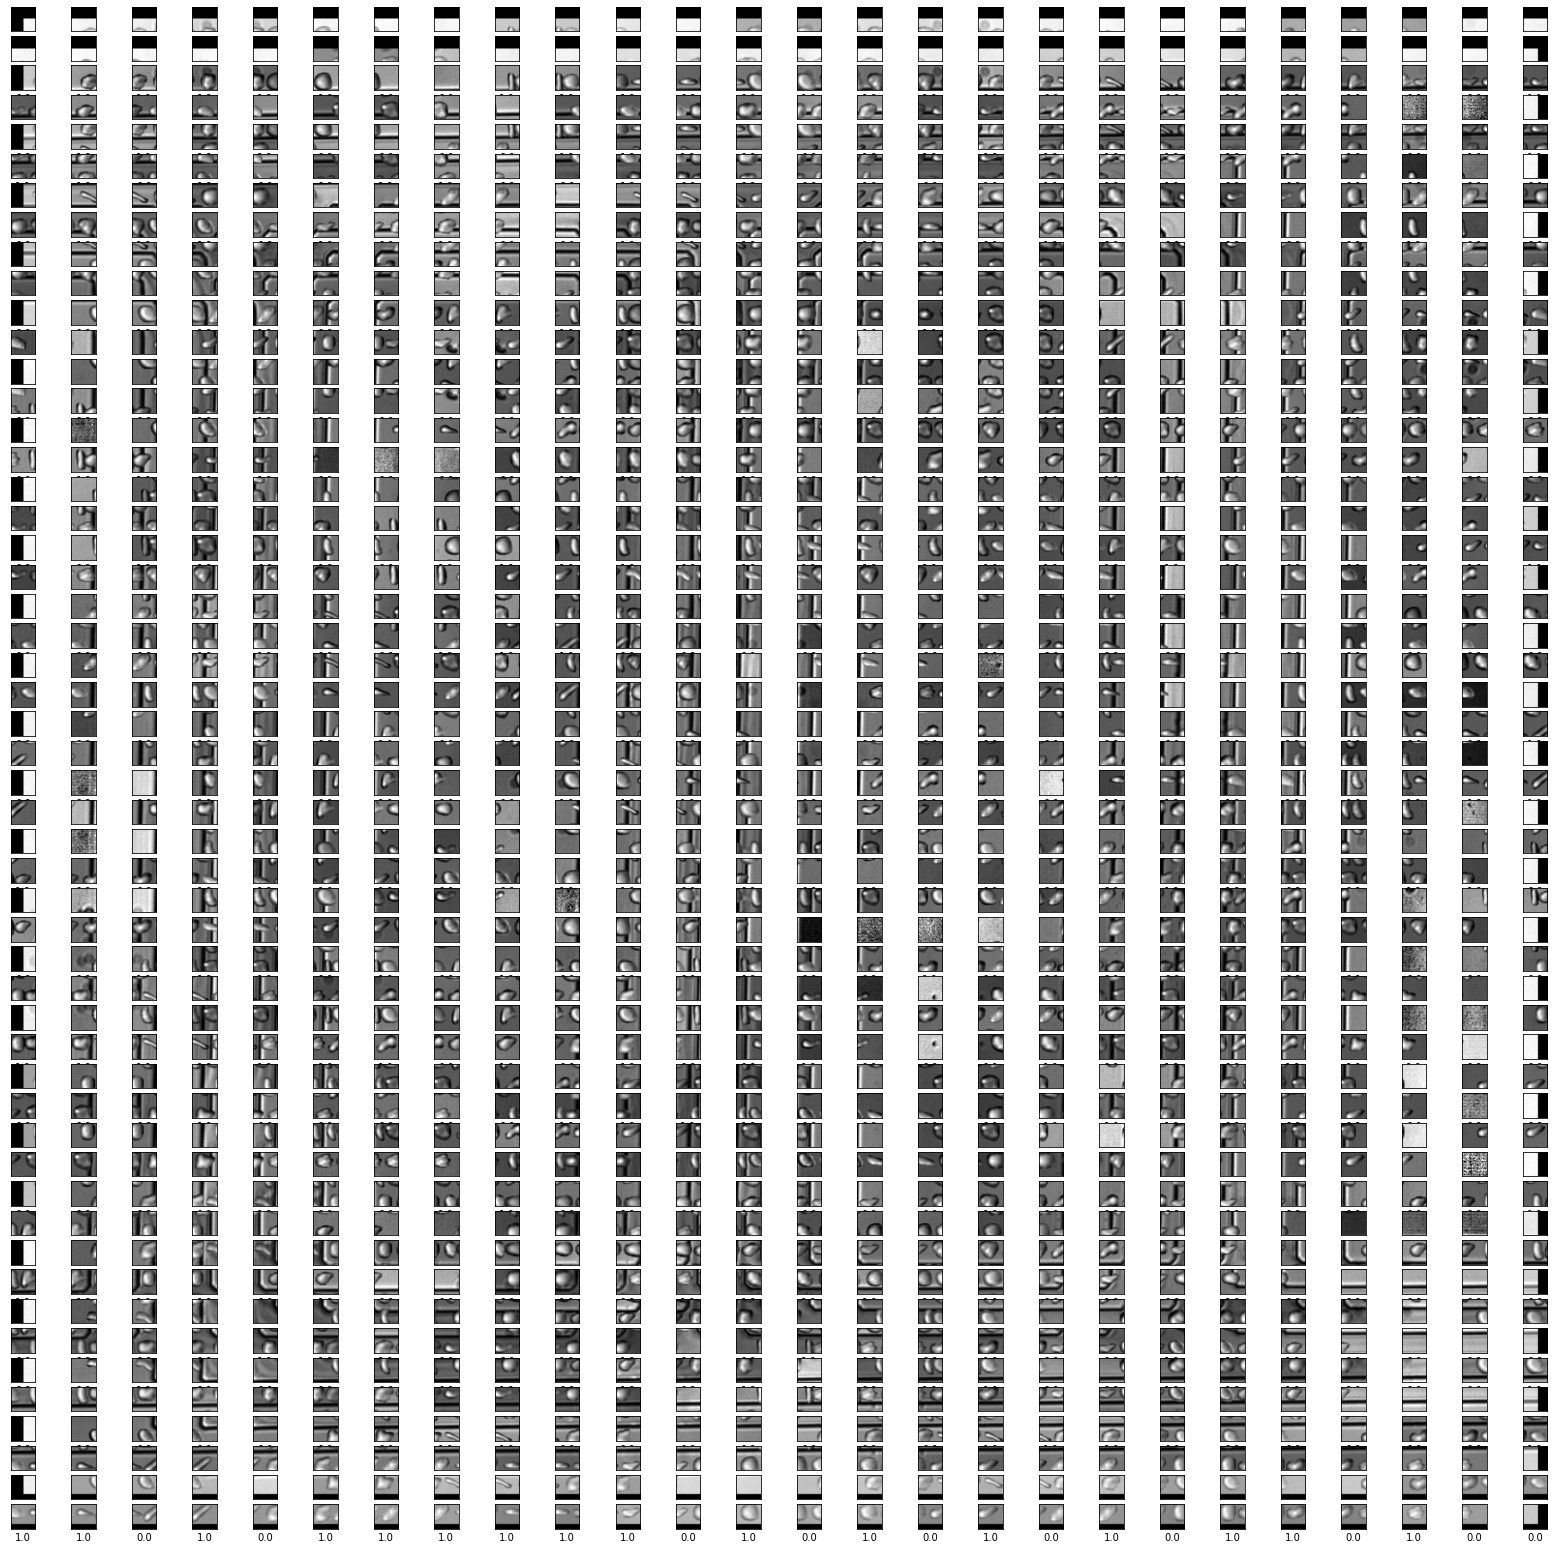

In [36]:
#サンプルplot
#読み込み
train_images_plt=[]
for i in range(window_num):
    train_images_plt.append(image_read_translator(train_images[i]))

plt.figure(figsize=(20,10))
for i in range(window_num):
    plt.subplot(window_height_num-2,window_width_num-2,i+1) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images_plt[i], cmap='binary_r')
    plt.xlabel(train_labels[i])

In [17]:
#batchを取得する関数

def get_batch(batch_size,input_images,input_diffs,input_labels):

    #global train_images, train_labels
    SIZE = len(input_images)
    # n_batchs
    n_batchs = SIZE//batch_size
    # for でyield
    i = 0
    #print('SIZE:',SIZE,', window_num:'window_num,', batch_size:',batch_size,', n_batchs:',n_batchs)
    print(SIZE)
    while (i < n_batchs):
        print("doing", i, "/", n_batchs)
        Y_batch = input_labels[(i * n_batchs):(i * n_batchs + batch_size)]
        
        #あるbatchのfilenameの配列を持っておく
        X_batch_img_name = input_images[(i * n_batchs):(i * n_batchs + batch_size)]
        X_batch_diff_name = input_diffs[(i * n_batchs):(i * n_batchs + batch_size)]

        # filenameにしたがってバッチのtensorを構築
        X_batch=[]
        for k in range(len(X_batch_img_name)):
            img_k=image_read_translator(X_batch_img_name[k])
            diff_k=image_read_translator(X_batch_diff_name[k])
            input_k=np.stack([img_k,diff_k],axis=2)
            X_batch.append(input_k)        
        X_batch=np.array(X_batch).reshape(batch_size, resize_window_size, resize_window_size, 2)        
        
        # これで(batch_size, window_size, window_size, 1)のtrainのテンソルが作られる
        i += 1
        yield X_batch, Y_batch

In [18]:
from keras import layers
from keras.layers import Input
from keras.models import Model

dropout_rate=0.3
filter_num=32

In [19]:
def make_model():
    
    inputs= Input(shape=(resize_window_size,resize_window_size,2))

    x=layers.Conv2D(filter_num*2, (3,3),activation='relu',padding='same')(inputs)
    #x=layers.MaxPooling2D(pool_size=(2,2))(x)
    #x=layers.Dropout(dropout_rate)(x)
    #x=layers.BatchNormalization()(x)

    #x=layers.Conv2D(filter_num*2, (3,3),activation='relu',padding='same')(x)
    x=layers.MaxPooling2D(pool_size=(2,2))(x)
    x=layers.Dropout(dropout_rate)(x)
    x=layers.BatchNormalization()(x)

    x=layers.Conv2D(filter_num*4, (3,3),activation='relu',padding='same')(x)
    x=layers.MaxPooling2D(pool_size=(2,2))(x)
    x=layers.Dropout(dropout_rate)(x)
    x=layers.BatchNormalization()(x)

    x=layers.Conv2D(filter_num*8, (3,3),activation='relu',padding='same')(x)
    x=layers.MaxPooling2D(pool_size=(2,2))(x)
    x=layers.Dropout(dropout_rate)(x)
    x=layers.BatchNormalization()(x)
    
    x=layers.Conv2D(filter_num*16, (3,3),activation='relu',padding='same')(x)
    x=layers.MaxPooling2D(pool_size=(2,2))(x)
    x=layers.Dropout(dropout_rate)(x)
    x=layers.BatchNormalization()(x)

    x=layers.Conv2D(filter_num*32, (3,3),activation='relu')(x)
    x=layers.Dropout(dropout_rate)(x)
    x=layers.BatchNormalization()(x)
    
    x=layers.Flatten()(x)
    outputs=layers.Dense(1,  activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy"])
    
    return model

In [20]:
model=make_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 64)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0     

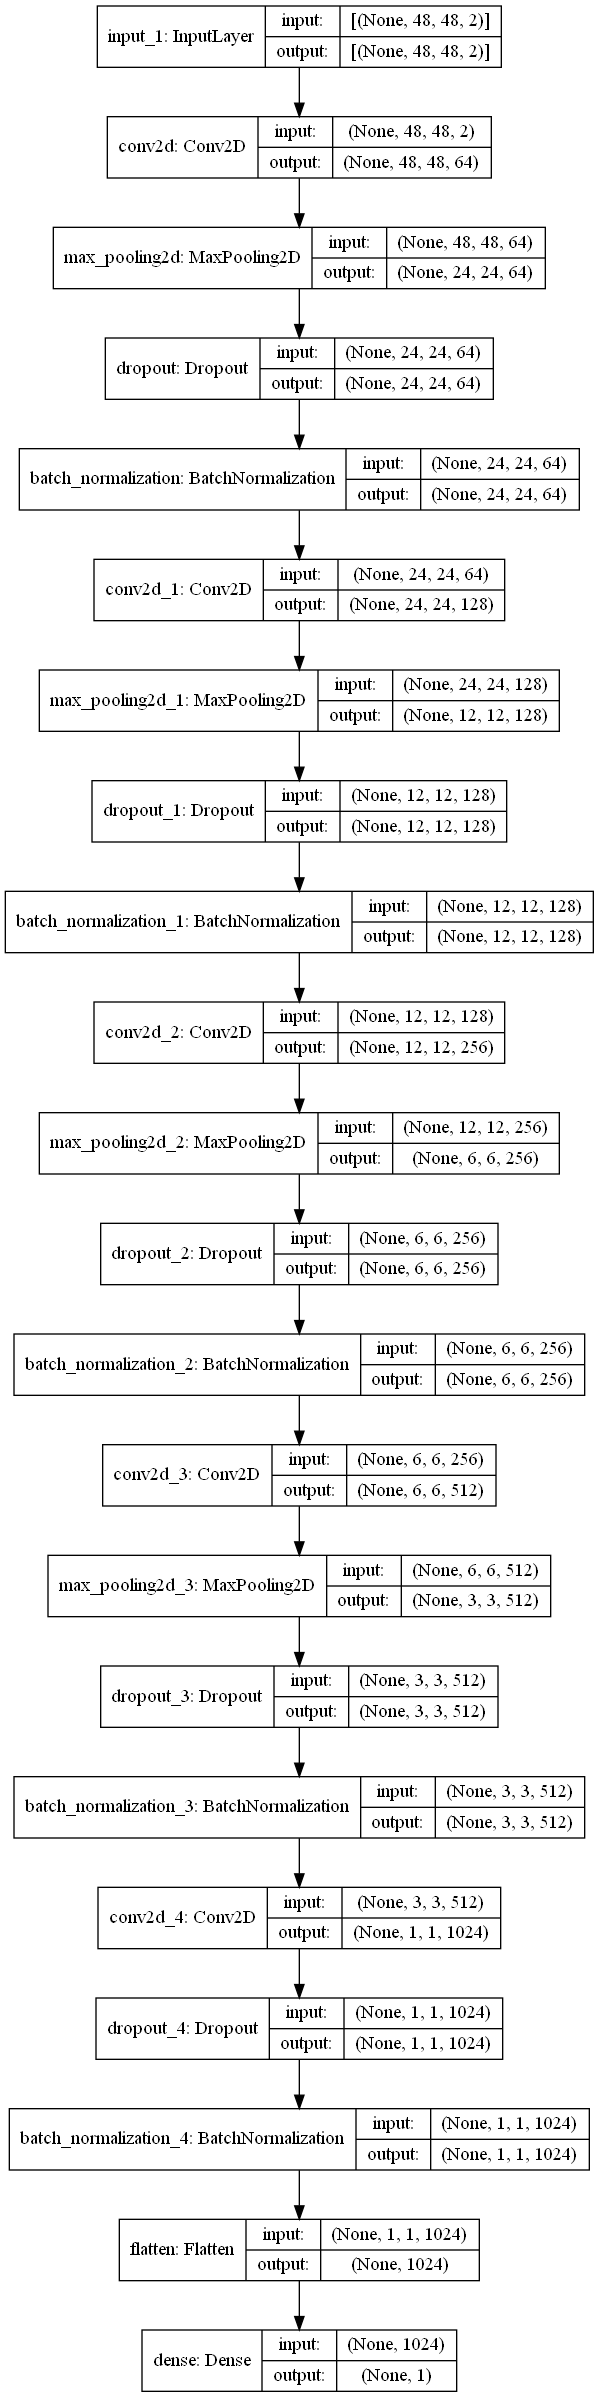

In [21]:
keras.utils.plot_model(model,'center_classifier.png',show_shapes=True)

In [22]:
#学習
def train(train_input_images_mini,train_input_diffs_mini,train_labels_mini,total_epoch_i,mini_set_k):
    print("=" * 50)
    print('TOTAL EPOCH:',total_epoch_i,'/',N_EPOCHS,'  MINI SET:',mini_set_k,'/',train_num//MINI_SET_NUM)
    acc ,loss= [],[]
    
    #load
    model=keras.models.load_model('center_classifier_middle.h5')
    
    # MINISETの画像をbatch_sizeごとに取り出して，訓練
    for X_batch, Y_batch in get_batch(batch_size,train_input_images_mini,train_input_diffs_mini,train_labels_mini):
        model.train_on_batch(X_batch, Y_batch)
        score = model.evaluate(X_batch, Y_batch)
        print("batch accuracy:", score[1])
        acc.append(score[1])
        loss.append(score[0])    

    history_train_acc.append(np.mean(acc))
    history_train_loss.append(np.mean(loss))
    
    #save
    model.save('center_classifier_middle.h5')
    
    #val
    score = model.evaluate(val_inputs, val_labels)
    print("Train accuracy", np.mean(acc))
    print("val loss:", score[0])
    print("Val accuracy:", score[1])
    history_val_loss.append(score[0])
    history_val_acc.append(score[1])
    
    global save_loss,save_acc,save_epoch,best_acc,best_epoch
    if total_epoch_i>0 and save_loss>score[0]:
        save_loss=score[0]
        model.save('center_classifier_best.h5')
        save_acc,save_epoch=score[1],(total_epoch_i,mini_set_k)
        
    if total_epoch_i>0 and best_acc<score[1]:
        best_acc,best_epoch=score[1],(total_epoch_i,mini_set_k)

In [23]:
model=make_model() #一応初期化しておく
model.save('center_classifier_middle.h5')

In [24]:
save_loss,save_acc,save_epoch=10,0,(0,0)
best_acc,best_epoch=0,(0,0)
history_train_acc,history_val_acc,history_train_loss,history_val_loss=[],[],[],[]

for total_epoch_i in range(N_EPOCHS):
    #MINI SETの訓練
    for mini_set_k in range(train_num//MINI_SET_NUM):
        train_input_images_mini=train_images[mini_set_k*MINI_SET_NUM*window_num:(mini_set_k+1)*MINI_SET_NUM*window_num]
        train_input_diffs_mini=train_diffs[mini_set_k*MINI_SET_NUM*window_num:(mini_set_k+1)*MINI_SET_NUM*window_num]
        train_labels_mini=train_labels[mini_set_k*MINI_SET_NUM*window_num:(mini_set_k+1)*MINI_SET_NUM*window_num]  
        train(train_input_images_mini,train_input_diffs_mini,train_labels_mini,total_epoch_i,mini_set_k)

TOTAL EPOCH: 0 / 100   MINI SET: 0 / 1
676000
doing 0 / 500
43/43 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4808
batch accuracy: 0.48076921701431274
doing 1 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5880
batch accuracy: 0.5880177617073059
doing 2 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.5984
batch accuracy: 0.598372757434845
doing 3 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6050
batch accuracy: 0.6050295829772949
doing 4 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5947
batch accuracy: 0.5946745276451111
doing 5 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5865
batch accuracy: 0.5865384340286255
doing 6 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5673
batch accuracy: 0.567307710647583
doi

43/43 [==============================] - 0s 3ms/step - loss: 1.6886 - accuracy: 0.6169
batch accuracy: 0.6168639063835144
doing 60 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.6961 - accuracy: 0.6220
batch accuracy: 0.6220414042472839
doing 61 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.7375 - accuracy: 0.6213
batch accuracy: 0.6213017702102661
doing 62 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.7625 - accuracy: 0.6198
batch accuracy: 0.6198225021362305
doing 63 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.7796 - accuracy: 0.6124
batch accuracy: 0.6124260425567627
doing 64 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.7636 - accuracy: 0.6080
batch accuracy: 0.607988178730011
doing 65 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.7746 - accuracy: 0.5962
batch accuracy: 0.5961538553237915
doing 66 / 500
43/43 [==============================] - 0

43/43 [==============================] - 0s 3ms/step - loss: 1.0379 - accuracy: 0.5858
batch accuracy: 0.5857987999916077
doing 120 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.9299 - accuracy: 0.5984
batch accuracy: 0.598372757434845
doing 121 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.8803 - accuracy: 0.6087
batch accuracy: 0.6087278127670288
doing 122 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.8554 - accuracy: 0.6280
batch accuracy: 0.6279585957527161
doing 123 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.9594 - accuracy: 0.6028
batch accuracy: 0.6028106212615967
doing 124 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.0867 - accuracy: 0.5843
batch accuracy: 0.584319531917572
doing 125 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.2498 - accuracy: 0.5525
batch accuracy: 0.5525147914886475
doing 126 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.8797 - accuracy: 0.6013
batch accuracy: 0.601331353187561
doing 179 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.0398 - accuracy: 0.5747
batch accuracy: 0.5747041702270508
doing 180 / 500
43/43 [==============================] - 0s 4ms/step - loss: 1.1749 - accuracy: 0.5688
batch accuracy: 0.5687869787216187
doing 181 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.2862 - accuracy: 0.5784
batch accuracy: 0.5784023404121399
doing 182 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.3458 - accuracy: 0.6102
batch accuracy: 0.6102070808410645
doing 183 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.4174 - accuracy: 0.6243
batch accuracy: 0.6242603659629822
doing 184 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.6005 - accuracy: 0.5895
batch accuracy: 0.5894970297813416
doing 185 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 2.2967 - accuracy: 0.5895
batch accuracy: 0.5894970297813416
doing 238 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.1233 - accuracy: 0.6021
batch accuracy: 0.6020709872245789
doing 239 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.9795 - accuracy: 0.6058
batch accuracy: 0.6057692170143127
doing 240 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.9272 - accuracy: 0.5991
batch accuracy: 0.5991124510765076
doing 241 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.9604 - accuracy: 0.5925
batch accuracy: 0.5924556255340576
doing 242 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.9860 - accuracy: 0.6013
batch accuracy: 0.601331353187561
doing 243 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.0885 - accuracy: 0.6006
batch accuracy: 0.6005917191505432
doing 244 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 2.9022 - accuracy: 0.6331
batch accuracy: 0.6331360936164856
doing 297 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.8655 - accuracy: 0.6317
batch accuracy: 0.63165682554245
doing 298 / 500
43/43 [==============================] - 0s 2ms/step - loss: 3.0801 - accuracy: 0.5902
batch accuracy: 0.5902366638183594
doing 299 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.9562 - accuracy: 0.5895
batch accuracy: 0.5894970297813416
doing 300 / 500
43/43 [==============================] - 0s 3ms/step - loss: 2.6710 - accuracy: 0.6021
batch accuracy: 0.6020709872245789
doing 301 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.4304 - accuracy: 0.6169
batch accuracy: 0.6168639063835144
doing 302 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.4918 - accuracy: 0.5999
batch accuracy: 0.5998520851135254
doing 303 / 500
43/43 [=============================

batch accuracy: 0.6471893787384033
doing 356 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.7662 - accuracy: 0.6472
batch accuracy: 0.6471893787384033
doing 357 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.8118 - accuracy: 0.6398
batch accuracy: 0.6397929191589355
doing 358 / 500
43/43 [==============================] - 0s 2ms/step - loss: 1.8745 - accuracy: 0.6398
batch accuracy: 0.6397929191589355
doing 359 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.1528 - accuracy: 0.6161
batch accuracy: 0.6161242723464966
doing 360 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.3757 - accuracy: 0.6228
batch accuracy: 0.6227810382843018
doing 361 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.7454 - accuracy: 0.6146
batch accuracy: 0.6146449446678162
doing 362 / 500
43/43 [==============================] - 0s 2ms/step - loss: 3.0075 - accuracy: 0.6213
batch accuracy: 0.6213017702102661

43/43 [==============================] - 0s 3ms/step - loss: 3.4258 - accuracy: 0.5865
batch accuracy: 0.5865384340286255
doing 416 / 500
43/43 [==============================] - 0s 3ms/step - loss: 3.7834 - accuracy: 0.5621
batch accuracy: 0.5621301531791687
doing 417 / 500
43/43 [==============================] - 0s 3ms/step - loss: 3.5806 - accuracy: 0.6036
batch accuracy: 0.6035503149032593
doing 418 / 500
43/43 [==============================] - 0s 3ms/step - loss: 3.6480 - accuracy: 0.6102
batch accuracy: 0.6102070808410645
doing 419 / 500
43/43 [==============================] - 0s 2ms/step - loss: 3.7361 - accuracy: 0.6109
batch accuracy: 0.610946774482727
doing 420 / 500
43/43 [==============================] - 0s 3ms/step - loss: 3.7412 - accuracy: 0.6058
batch accuracy: 0.6057692170143127
doing 421 / 500
43/43 [==============================] - 0s 2ms/step - loss: 3.6484 - accuracy: 0.6036
batch accuracy: 0.6035503149032593
doing 422 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 2.9535 - accuracy: 0.6169
batch accuracy: 0.6168639063835144
doing 475 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.8825 - accuracy: 0.6324
batch accuracy: 0.6323964595794678
doing 476 / 500
43/43 [==============================] - 0s 2ms/step - loss: 2.9123 - accuracy: 0.6391
batch accuracy: 0.639053225517273
doing 477 / 500
43/43 [==============================] - 0s 2ms/step - loss: 3.2344 - accuracy: 0.6228
batch accuracy: 0.6227810382843018
doing 478 / 500
43/43 [==============================] - 0s 3ms/step - loss: 3.7906 - accuracy: 0.5851
batch accuracy: 0.5850591659545898
doing 479 / 500
43/43 [==============================] - 0s 3ms/step - loss: 4.0196 - accuracy: 0.5865
batch accuracy: 0.5865384340286255
doing 480 / 500
43/43 [==============================] - 0s 3ms/step - loss: 4.4272 - accuracy: 0.5717
batch accuracy: 0.5717455744743347
doing 481 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 2.9778 - accuracy: 0.5629
batch accuracy: 0.5628698468208313
doing 33 / 500
43/43 [==============================] - 0s 3ms/step - loss: 2.8964 - accuracy: 0.5865
batch accuracy: 0.5865384340286255
doing 34 / 500
43/43 [==============================] - 0s 3ms/step - loss: 3.2110 - accuracy: 0.5710
batch accuracy: 0.5710059404373169
doing 35 / 500
43/43 [==============================] - 0s 3ms/step - loss: 3.1935 - accuracy: 0.5991
batch accuracy: 0.5991124510765076
doing 36 / 500
43/43 [==============================] - 0s 3ms/step - loss: 2.9129 - accuracy: 0.6383
batch accuracy: 0.6383135914802551
doing 37 / 500
43/43 [==============================] - 0s 3ms/step - loss: 3.0987 - accuracy: 0.6139
batch accuracy: 0.6139053106307983
doing 38 / 500
43/43 [==============================] - 0s 3ms/step - loss: 3.4863 - accuracy: 0.5732
batch accuracy: 0.5732248425483704
doing 39 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 3ms/step - loss: 1.3267 - accuracy: 0.6857
batch accuracy: 0.6856508851051331
doing 93 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.4770 - accuracy: 0.6790
batch accuracy: 0.6789940595626831
doing 94 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.6052 - accuracy: 0.6768
batch accuracy: 0.6767751574516296
doing 95 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.8307 - accuracy: 0.6538
batch accuracy: 0.6538461446762085
doing 96 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.8934 - accuracy: 0.6324
batch accuracy: 0.6323964595794678
doing 97 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.9499 - accuracy: 0.6250
batch accuracy: 0.625
doing 98 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.8872 - accuracy: 0.6294
batch accuracy: 0.6294378638267517
doing 99 / 500
43/43 [==============================] - 0s 3ms/step -

43/43 [==============================] - 0s 3ms/step - loss: 2.5441 - accuracy: 0.6213
batch accuracy: 0.6213017702102661
doing 152 / 500
43/43 [==============================] - 0s 3ms/step - loss: 2.5903 - accuracy: 0.6080
batch accuracy: 0.607988178730011
doing 153 / 500
43/43 [==============================] - 0s 3ms/step - loss: 2.4406 - accuracy: 0.6191
batch accuracy: 0.6190828680992126
doing 154 / 500
43/43 [==============================] - 0s 3ms/step - loss: 2.3879 - accuracy: 0.5999
batch accuracy: 0.5998520851135254
doing 155 / 500
43/43 [==============================] - 0s 3ms/step - loss: 2.0457 - accuracy: 0.6206
batch accuracy: 0.6205621361732483
doing 156 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.5364 - accuracy: 0.6509
batch accuracy: 0.6508875489234924
doing 157 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.1623 - accuracy: 0.6990
batch accuracy: 0.6989644765853882
doing 158 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.5080 - accuracy: 0.7788
batch accuracy: 0.7788461446762085
doing 211 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4690 - accuracy: 0.7825
batch accuracy: 0.7825443744659424
doing 212 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4853 - accuracy: 0.7655
batch accuracy: 0.7655325531959534
doing 213 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4481 - accuracy: 0.7892
batch accuracy: 0.7892012000083923
doing 214 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4797 - accuracy: 0.7914
batch accuracy: 0.7914201021194458
doing 215 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4885 - accuracy: 0.7796
batch accuracy: 0.7795857787132263
doing 216 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.5396 - accuracy: 0.7611
batch accuracy: 0.7610946893692017
doing 217 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.4856 - accuracy: 0.7996
batch accuracy: 0.7995561957359314
doing 270 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.5035 - accuracy: 0.8033
batch accuracy: 0.8032544255256653
doing 271 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.5774 - accuracy: 0.7611
batch accuracy: 0.7610946893692017
doing 272 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.7189
batch accuracy: 0.7189348936080933
doing 273 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.9354 - accuracy: 0.6797
batch accuracy: 0.6797337532043457
doing 274 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.9758 - accuracy: 0.6908
batch accuracy: 0.6908283829689026
doing 275 / 500
43/43 [==============================] - 0s 3ms/step - loss: 1.0096 - accuracy: 0.6716
batch accuracy: 0.6715976595878601
doing 276 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.5954 - accuracy: 0.7641
batch accuracy: 0.764053225517273
doing 329 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.5276 - accuracy: 0.7914
batch accuracy: 0.7914201021194458
doing 330 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.5070 - accuracy: 0.8158
batch accuracy: 0.8158283829689026
doing 331 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.5633 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 332 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.8084
batch accuracy: 0.8084319233894348
doing 333 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.7973
batch accuracy: 0.7973372936248779
doing 334 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.5350 - accuracy: 0.8077
batch accuracy: 0.807692289352417
doing 335 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.4761 - accuracy: 0.8018
batch accuracy: 0.8017751574516296
doing 388 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4616 - accuracy: 0.7892
batch accuracy: 0.7892012000083923
doing 389 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4196 - accuracy: 0.7996
batch accuracy: 0.7995561957359314
doing 390 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4163 - accuracy: 0.7959
batch accuracy: 0.7958579659461975
doing 391 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4232 - accuracy: 0.7996
batch accuracy: 0.7995561957359314
doing 392 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4430 - accuracy: 0.7774
batch accuracy: 0.7773668766021729
doing 393 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4578 - accuracy: 0.7707
batch accuracy: 0.7707100510597229
doing 394 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3830 - accuracy: 0.8070
batch accuracy: 0.8069526553153992
doing 447 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3582 - accuracy: 0.8358
batch accuracy: 0.8357987999916077
doing 448 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3511 - accuracy: 0.8639
batch accuracy: 0.8639053106307983
doing 449 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3926 - accuracy: 0.8351
batch accuracy: 0.8350591659545898
doing 450 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4232 - accuracy: 0.8025
batch accuracy: 0.8025147914886475
doing 451 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4164 - accuracy: 0.8070
batch accuracy: 0.8069526553153992
doing 452 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4023 - accuracy: 0.8055
batch accuracy: 0.8054733872413635
doing 453 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3468 - accuracy: 0.8291
batch accuracy: 0.8291420340538025
doing 4 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3313 - accuracy: 0.8402
batch accuracy: 0.8402366638183594
doing 5 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3441 - accuracy: 0.8351
batch accuracy: 0.8350591659545898
doing 6 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3757 - accuracy: 0.8203
batch accuracy: 0.8202662467956543
doing 7 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3582 - accuracy: 0.8351
batch accuracy: 0.8350591659545898
doing 8 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3397 - accuracy: 0.8454
batch accuracy: 0.8454142212867737
doing 9 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3510 - accuracy: 0.8358
batch accuracy: 0.8357987999916077
doing 10 / 500
43/43 [==============================] - 0s 3ms

43/43 [==============================] - 0s 2ms/step - loss: 0.3520 - accuracy: 0.8077
batch accuracy: 0.807692289352417
doing 64 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3229 - accuracy: 0.8299
batch accuracy: 0.8298816680908203
doing 65 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3432 - accuracy: 0.8143
batch accuracy: 0.8143491148948669
doing 66 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3080 - accuracy: 0.8299
batch accuracy: 0.8298816680908203
doing 67 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3108 - accuracy: 0.8247
batch accuracy: 0.8247041702270508
doing 68 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3114 - accuracy: 0.8358
batch accuracy: 0.8357987999916077
doing 69 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3346 - accuracy: 0.8358
batch accuracy: 0.8357987999916077
doing 70 / 500
43/43 [==============================] - 0

43/43 [==============================] - 0s 3ms/step - loss: 0.3446 - accuracy: 0.8262
batch accuracy: 0.8261834383010864
doing 124 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3512 - accuracy: 0.8314
batch accuracy: 0.831360936164856
doing 125 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3541 - accuracy: 0.8351
batch accuracy: 0.8350591659545898
doing 126 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3794 - accuracy: 0.8143
batch accuracy: 0.8143491148948669
doing 127 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3602 - accuracy: 0.8173
batch accuracy: 0.817307710647583
doing 128 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3624 - accuracy: 0.8232
batch accuracy: 0.8232248425483704
doing 129 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3517 - accuracy: 0.8299
batch accuracy: 0.8298816680908203
doing 130 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3255 - accuracy: 0.8328
batch accuracy: 0.8328402638435364
doing 183 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2928 - accuracy: 0.8425
batch accuracy: 0.8424556255340576
doing 184 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3123 - accuracy: 0.8336
batch accuracy: 0.8335798978805542
doing 185 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3363 - accuracy: 0.8328
batch accuracy: 0.8328402638435364
doing 186 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3507 - accuracy: 0.8284
batch accuracy: 0.8284023404121399
doing 187 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3785 - accuracy: 0.8158
batch accuracy: 0.8158283829689026
doing 188 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3853 - accuracy: 0.8092
batch accuracy: 0.8091716170310974
doing 189 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2903 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 242 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3240 - accuracy: 0.8454
batch accuracy: 0.8454142212867737
doing 243 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3520 - accuracy: 0.8336
batch accuracy: 0.8335798978805542
doing 244 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3918 - accuracy: 0.8240
batch accuracy: 0.8239644765853882
doing 245 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4309 - accuracy: 0.7996
batch accuracy: 0.7995561957359314
doing 246 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4322 - accuracy: 0.8010
batch accuracy: 0.8010355234146118
doing 247 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4631 - accuracy: 0.7788
batch accuracy: 0.7788461446762085
doing 248 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3523 - accuracy: 0.8484
batch accuracy: 0.848372757434845
doing 301 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3408 - accuracy: 0.8513
batch accuracy: 0.851331353187561
doing 302 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3600 - accuracy: 0.8410
batch accuracy: 0.840976357460022
doing 303 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3935 - accuracy: 0.8299
batch accuracy: 0.8298816680908203
doing 304 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4184 - accuracy: 0.8084
batch accuracy: 0.8084319233894348
doing 305 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4105 - accuracy: 0.7944
batch accuracy: 0.7943786978721619
doing 306 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3844 - accuracy: 0.7951
batch accuracy: 0.7951183319091797
doing 307 / 500
43/43 [==============================

43/43 [==============================] - 0s 3ms/step - loss: 0.4669 - accuracy: 0.7996
batch accuracy: 0.7995561957359314
doing 360 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4368 - accuracy: 0.8018
batch accuracy: 0.8017751574516296
doing 361 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4429 - accuracy: 0.7870
batch accuracy: 0.7869822382926941
doing 362 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3885 - accuracy: 0.8225
batch accuracy: 0.8224852085113525
doing 363 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3964 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 364 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3659 - accuracy: 0.8314
batch accuracy: 0.831360936164856
doing 365 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3803 - accuracy: 0.8210
batch accuracy: 0.8210059404373169
doing 366 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2809 - accuracy: 0.8617
batch accuracy: 0.8616864085197449
doing 419 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3078 - accuracy: 0.8380
batch accuracy: 0.8380177617073059
doing 420 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3325 - accuracy: 0.8232
batch accuracy: 0.8232248425483704
doing 421 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3168 - accuracy: 0.8306
batch accuracy: 0.8306213021278381
doing 422 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3376 - accuracy: 0.8173
batch accuracy: 0.817307710647583
doing 423 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3214 - accuracy: 0.8417
batch accuracy: 0.8417159914970398
doing 424 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3365 - accuracy: 0.8321
batch accuracy: 0.8321005702018738
doing 425 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2958 - accuracy: 0.8395
batch accuracy: 0.8394970297813416
doing 478 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3182 - accuracy: 0.8262
batch accuracy: 0.8261834383010864
doing 479 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3444 - accuracy: 0.8232
batch accuracy: 0.8232248425483704
doing 480 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3468 - accuracy: 0.8314
batch accuracy: 0.831360936164856
doing 481 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3167 - accuracy: 0.8410
batch accuracy: 0.840976357460022
doing 482 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2678 - accuracy: 0.8720
batch accuracy: 0.8720414042472839
doing 483 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2655 - accuracy: 0.8757
batch accuracy: 0.8757396340370178
doing 484 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3511 - accuracy: 0.8173
batch accuracy: 0.817307710647583
doing 36 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3218 - accuracy: 0.8328
batch accuracy: 0.8328402638435364
doing 37 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2882 - accuracy: 0.8447
batch accuracy: 0.8446745276451111
doing 38 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3001 - accuracy: 0.8380
batch accuracy: 0.8380177617073059
doing 39 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2903 - accuracy: 0.8462
batch accuracy: 0.8461538553237915
doing 40 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3390 - accuracy: 0.8306
batch accuracy: 0.8306213021278381
doing 41 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3537 - accuracy: 0.8151
batch accuracy: 0.8150887489318848
doing 42 / 500
43/43 [==============================] - 0

43/43 [==============================] - 0s 2ms/step - loss: 0.2755 - accuracy: 0.8572
batch accuracy: 0.8572485446929932
doing 96 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3159 - accuracy: 0.8343
batch accuracy: 0.834319531917572
doing 97 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3386 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 98 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3556 - accuracy: 0.8269
batch accuracy: 0.8269230723381042
doing 99 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3514 - accuracy: 0.8173
batch accuracy: 0.817307710647583
doing 100 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3270 - accuracy: 0.8328
batch accuracy: 0.8328402638435364
doing 101 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3058 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 102 / 500
43/43 [==============================] -

43/43 [==============================] - 0s 3ms/step - loss: 0.3327 - accuracy: 0.8188
batch accuracy: 0.8187869787216187
doing 155 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3465 - accuracy: 0.8240
batch accuracy: 0.8239644765853882
doing 156 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3224 - accuracy: 0.8425
batch accuracy: 0.8424556255340576
doing 157 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2743 - accuracy: 0.8676
batch accuracy: 0.8676035404205322
doing 158 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2932 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 159 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2599 - accuracy: 0.8698
batch accuracy: 0.8698225021362305
doing 160 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2556 - accuracy: 0.8765
batch accuracy: 0.8764792680740356
doing 161 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3550 - accuracy: 0.8010
batch accuracy: 0.8010355234146118
doing 214 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3663 - accuracy: 0.8092
batch accuracy: 0.8091716170310974
doing 215 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3528 - accuracy: 0.8210
batch accuracy: 0.8210059404373169
doing 216 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3602 - accuracy: 0.8210
batch accuracy: 0.8210059404373169
doing 217 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3280 - accuracy: 0.8432
batch accuracy: 0.8431952595710754
doing 218 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2726 - accuracy: 0.8706
batch accuracy: 0.8705621361732483
doing 219 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3076 - accuracy: 0.8476
batch accuracy: 0.8476331233978271
doing 220 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3394 - accuracy: 0.8262
batch accuracy: 0.8261834383010864
doing 273 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3739 - accuracy: 0.8010
batch accuracy: 0.8010355234146118
doing 274 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3546 - accuracy: 0.8136
batch accuracy: 0.8136094808578491
doing 275 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3558 - accuracy: 0.8121
batch accuracy: 0.8121301531791687
doing 276 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3748 - accuracy: 0.8092
batch accuracy: 0.8091716170310974
doing 277 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4032 - accuracy: 0.7966
batch accuracy: 0.7965976595878601
doing 278 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4250 - accuracy: 0.7811
batch accuracy: 0.7810651063919067
doing 279 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3070 - accuracy: 0.8743
batch accuracy: 0.8742603659629822
doing 332 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2994 - accuracy: 0.8698
batch accuracy: 0.8698225021362305
doing 333 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3035 - accuracy: 0.8521
batch accuracy: 0.8520709872245789
doing 334 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3020 - accuracy: 0.8491
batch accuracy: 0.8491124510765076
doing 335 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3372 - accuracy: 0.8232
batch accuracy: 0.8232248425483704
doing 336 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3560 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 337 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3789 - accuracy: 0.8166
batch accuracy: 0.8165680766105652
doing 338 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3119 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 391 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3098 - accuracy: 0.8439
batch accuracy: 0.8439348936080933
doing 392 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3217 - accuracy: 0.8343
batch accuracy: 0.834319531917572
doing 393 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3326 - accuracy: 0.8291
batch accuracy: 0.8291420340538025
doing 394 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3464 - accuracy: 0.8247
batch accuracy: 0.8247041702270508
doing 395 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3297 - accuracy: 0.8336
batch accuracy: 0.8335798978805542
doing 396 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3106 - accuracy: 0.8439
batch accuracy: 0.8439348936080933
doing 397 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3095 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 450 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3349 - accuracy: 0.8254
batch accuracy: 0.8254438042640686
doing 451 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3218 - accuracy: 0.8269
batch accuracy: 0.8269230723381042
doing 452 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3182 - accuracy: 0.8299
batch accuracy: 0.8298816680908203
doing 453 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3319 - accuracy: 0.8306
batch accuracy: 0.8306213021278381
doing 454 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3585 - accuracy: 0.8203
batch accuracy: 0.8202662467956543
doing 455 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3520 - accuracy: 0.8240
batch accuracy: 0.8239644765853882
doing 456 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3393 - accuracy: 0.8306
batch accuracy: 0.8306213021278381
doing 7 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3223 - accuracy: 0.8447
batch accuracy: 0.8446745276451111
doing 8 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2964 - accuracy: 0.8521
batch accuracy: 0.8520709872245789
doing 9 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3130 - accuracy: 0.8476
batch accuracy: 0.8476331233978271
doing 10 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3175 - accuracy: 0.8358
batch accuracy: 0.8357987999916077
doing 11 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3135 - accuracy: 0.8439
batch accuracy: 0.8439348936080933
doing 12 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3258 - accuracy: 0.8291
batch accuracy: 0.8291420340538025
doing 13 / 500
43/43 [==============================] - 0s 

43/43 [==============================] - 0s 3ms/step - loss: 0.2747 - accuracy: 0.8491
batch accuracy: 0.8491124510765076
doing 67 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2737 - accuracy: 0.8462
batch accuracy: 0.8461538553237915
doing 68 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2744 - accuracy: 0.8669
batch accuracy: 0.8668639063835144
doing 69 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2897 - accuracy: 0.8602
batch accuracy: 0.8602070808410645
doing 70 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2944 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 71 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3131 - accuracy: 0.8462
batch accuracy: 0.8461538553237915
doing 72 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3416 - accuracy: 0.8336
batch accuracy: 0.8335798978805542
doing 73 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 2ms/step - loss: 0.3493 - accuracy: 0.8151
batch accuracy: 0.8150887489318848
doing 127 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3277 - accuracy: 0.8240
batch accuracy: 0.8239644765853882
doing 128 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3267 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 129 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3150 - accuracy: 0.8395
batch accuracy: 0.8394970297813416
doing 130 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3168 - accuracy: 0.8462
batch accuracy: 0.8461538553237915
doing 131 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2905 - accuracy: 0.8602
batch accuracy: 0.8602070808410645
doing 132 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2819 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 133 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3084 - accuracy: 0.8439
batch accuracy: 0.8439348936080933
doing 186 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3299 - accuracy: 0.8269
batch accuracy: 0.8269230723381042
doing 187 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3528 - accuracy: 0.8299
batch accuracy: 0.8298816680908203
doing 188 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3586 - accuracy: 0.8210
batch accuracy: 0.8210059404373169
doing 189 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3488 - accuracy: 0.8262
batch accuracy: 0.8261834383010864
doing 190 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3102 - accuracy: 0.8395
batch accuracy: 0.8394970297813416
doing 191 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3159 - accuracy: 0.8402
batch accuracy: 0.8402366638183594
doing 192 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3700 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 245 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4138 - accuracy: 0.7973
batch accuracy: 0.7973372936248779
doing 246 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3907 - accuracy: 0.8129
batch accuracy: 0.8128698468208313
doing 247 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3935 - accuracy: 0.8040
batch accuracy: 0.8039940595626831
doing 248 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3428 - accuracy: 0.8291
batch accuracy: 0.8291420340538025
doing 249 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3560 - accuracy: 0.8254
batch accuracy: 0.8254438042640686
doing 250 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3199 - accuracy: 0.8380
batch accuracy: 0.8380177617073059
doing 251 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2917 - accuracy: 0.8580
batch accuracy: 0.857988178730011
doing 304 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2965 - accuracy: 0.8432
batch accuracy: 0.8431952595710754
doing 305 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3126 - accuracy: 0.8388
batch accuracy: 0.8387573957443237
doing 306 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3109 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 307 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2956 - accuracy: 0.8328
batch accuracy: 0.8328402638435364
doing 308 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3051 - accuracy: 0.8314
batch accuracy: 0.831360936164856
doing 309 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2971 - accuracy: 0.8365
batch accuracy: 0.8365384340286255
doing 310 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3459 - accuracy: 0.8291
batch accuracy: 0.8291420340538025
doing 363 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3712 - accuracy: 0.8217
batch accuracy: 0.8217455744743347
doing 364 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3437 - accuracy: 0.8380
batch accuracy: 0.8380177617073059
doing 365 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3844 - accuracy: 0.8092
batch accuracy: 0.8091716170310974
doing 366 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4148 - accuracy: 0.7959
batch accuracy: 0.7958579659461975
doing 367 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3981 - accuracy: 0.8055
batch accuracy: 0.8054733872413635
doing 368 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3271 - accuracy: 0.8491
batch accuracy: 0.8491124510765076
doing 369 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2940 - accuracy: 0.8439
batch accuracy: 0.8439348936080933
doing 422 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3132 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 423 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2957 - accuracy: 0.8499
batch accuracy: 0.8498520851135254
doing 424 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3119 - accuracy: 0.8410
batch accuracy: 0.840976357460022
doing 425 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3070 - accuracy: 0.8402
batch accuracy: 0.8402366638183594
doing 426 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2933 - accuracy: 0.8476
batch accuracy: 0.8476331233978271
doing 427 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3000 - accuracy: 0.8417
batch accuracy: 0.8417159914970398
doing 428 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3370 - accuracy: 0.8417
batch accuracy: 0.8417159914970398
doing 481 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2983 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 482 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2444 - accuracy: 0.8787
batch accuracy: 0.8786982297897339
doing 483 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2538 - accuracy: 0.8817
batch accuracy: 0.88165682554245
doing 484 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2638 - accuracy: 0.8728
batch accuracy: 0.8727810382843018
doing 485 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2656 - accuracy: 0.8632
batch accuracy: 0.8631656765937805
doing 486 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2626 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 487 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2853 - accuracy: 0.8499
batch accuracy: 0.8498520851135254
doing 39 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2683 - accuracy: 0.8572
batch accuracy: 0.8572485446929932
doing 40 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3175 - accuracy: 0.8395
batch accuracy: 0.8394970297813416
doing 41 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3360 - accuracy: 0.8262
batch accuracy: 0.8261834383010864
doing 42 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3273 - accuracy: 0.8269
batch accuracy: 0.8269230723381042
doing 43 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2636 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 44 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2377 - accuracy: 0.8772
batch accuracy: 0.8772189617156982
doing 45 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 3ms/step - loss: 0.3266 - accuracy: 0.8217
batch accuracy: 0.8217455744743347
doing 99 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3132 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 100 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.8454
batch accuracy: 0.8454142212867737
doing 101 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2847 - accuracy: 0.8595
batch accuracy: 0.8594674468040466
doing 102 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2957 - accuracy: 0.8632
batch accuracy: 0.8631656765937805
doing 103 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3083 - accuracy: 0.8572
batch accuracy: 0.8572485446929932
doing 104 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3312 - accuracy: 0.8328
batch accuracy: 0.8328402638435364
doing 105 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3012 - accuracy: 0.8632
batch accuracy: 0.8631656765937805
doing 158 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3077 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 159 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2674 - accuracy: 0.8691
batch accuracy: 0.8690828680992126
doing 160 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2522 - accuracy: 0.8780
batch accuracy: 0.8779585957527161
doing 161 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2713 - accuracy: 0.8639
batch accuracy: 0.8639053106307983
doing 162 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2989 - accuracy: 0.8469
batch accuracy: 0.8468934893608093
doing 163 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2949 - accuracy: 0.8410
batch accuracy: 0.840976357460022
doing 164 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3491 - accuracy: 0.8247
batch accuracy: 0.8247041702270508
doing 217 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3226 - accuracy: 0.8410
batch accuracy: 0.840976357460022
doing 218 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2711 - accuracy: 0.8713
batch accuracy: 0.8713017702102661
doing 219 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3115 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 220 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3079 - accuracy: 0.8454
batch accuracy: 0.8454142212867737
doing 221 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3076 - accuracy: 0.8462
batch accuracy: 0.8461538553237915
doing 222 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2712 - accuracy: 0.8602
batch accuracy: 0.8602070808410645
doing 223 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3207 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 276 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3335 - accuracy: 0.8203
batch accuracy: 0.8202662467956543
doing 277 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3486 - accuracy: 0.8136
batch accuracy: 0.8136094808578491
doing 278 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3483 - accuracy: 0.8180
batch accuracy: 0.8180473446846008
doing 279 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3357 - accuracy: 0.8225
batch accuracy: 0.8224852085113525
doing 280 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3461 - accuracy: 0.8203
batch accuracy: 0.8202662467956543
doing 281 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3441 - accuracy: 0.8203
batch accuracy: 0.8202662467956543
doing 282 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2627 - accuracy: 0.8543
batch accuracy: 0.8542899489402771
doing 335 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2973 - accuracy: 0.8402
batch accuracy: 0.8402366638183594
doing 336 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3147 - accuracy: 0.8343
batch accuracy: 0.834319531917572
doing 337 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3552 - accuracy: 0.8232
batch accuracy: 0.8232248425483704
doing 338 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3961 - accuracy: 0.7914
batch accuracy: 0.7914201021194458
doing 339 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3973 - accuracy: 0.7855
batch accuracy: 0.7855029702186584
doing 340 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3310 - accuracy: 0.8247
batch accuracy: 0.8247041702270508
doing 341 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3377 - accuracy: 0.8262
batch accuracy: 0.8261834383010864
doing 394 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3537 - accuracy: 0.8173
batch accuracy: 0.817307710647583
doing 395 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3551 - accuracy: 0.8173
batch accuracy: 0.817307710647583
doing 396 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3371 - accuracy: 0.8328
batch accuracy: 0.8328402638435364
doing 397 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3267 - accuracy: 0.8343
batch accuracy: 0.834319531917572
doing 398 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.8550
batch accuracy: 0.8550295829772949
doing 399 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2726 - accuracy: 0.8683
batch accuracy: 0.86834317445755
doing 400 / 500
43/43 [==============================] 

43/43 [==============================] - 0s 3ms/step - loss: 0.3392 - accuracy: 0.8254
batch accuracy: 0.8254438042640686
doing 453 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3489 - accuracy: 0.8240
batch accuracy: 0.8239644765853882
doing 454 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3564 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 455 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3371 - accuracy: 0.8388
batch accuracy: 0.8387573957443237
doing 456 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3058 - accuracy: 0.8617
batch accuracy: 0.8616864085197449
doing 457 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2907 - accuracy: 0.8587
batch accuracy: 0.8587278127670288
doing 458 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2952 - accuracy: 0.8513
batch accuracy: 0.851331353187561
doing 459 / 500
43/43 [============================

batch accuracy: 0.8572485446929932
doing 10 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2993 - accuracy: 0.8469
batch accuracy: 0.8468934893608093
doing 11 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2925 - accuracy: 0.8572
batch accuracy: 0.8572485446929932
doing 12 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2983 - accuracy: 0.8462
batch accuracy: 0.8461538553237915
doing 13 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3116 - accuracy: 0.8388
batch accuracy: 0.8387573957443237
doing 14 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2986 - accuracy: 0.8454
batch accuracy: 0.8454142212867737
doing 15 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2646 - accuracy: 0.8595
batch accuracy: 0.8594674468040466
doing 16 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2649 - accuracy: 0.8617
batch accuracy: 0.8616864085197449
doing 

43/43 [==============================] - 0s 3ms/step - loss: 0.3065 - accuracy: 0.8506
batch accuracy: 0.8505917191505432
doing 70 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3172 - accuracy: 0.8410
batch accuracy: 0.840976357460022
doing 71 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3388 - accuracy: 0.8203
batch accuracy: 0.8202662467956543
doing 72 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3624 - accuracy: 0.8084
batch accuracy: 0.8084319233894348
doing 73 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3249 - accuracy: 0.8425
batch accuracy: 0.8424556255340576
doing 74 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2921 - accuracy: 0.8550
batch accuracy: 0.8550295829772949
doing 75 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2795 - accuracy: 0.8632
batch accuracy: 0.8631656765937805
doing 76 / 500
43/43 [==============================] - 0

43/43 [==============================] - 0s 3ms/step - loss: 0.3028 - accuracy: 0.8550
batch accuracy: 0.8550295829772949
doing 130 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2951 - accuracy: 0.8602
batch accuracy: 0.8602070808410645
doing 131 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2661 - accuracy: 0.8735
batch accuracy: 0.8735207319259644
doing 132 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2551 - accuracy: 0.8706
batch accuracy: 0.8705621361732483
doing 133 / 500
43/43 [==============================] - 0s 7ms/step - loss: 0.2542 - accuracy: 0.8757
batch accuracy: 0.8757396340370178
doing 134 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2708 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 135 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2826 - accuracy: 0.8595
batch accuracy: 0.8594674468040466
doing 136 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3827 - accuracy: 0.8121
batch accuracy: 0.8121301531791687
doing 189 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3535 - accuracy: 0.8254
batch accuracy: 0.8254438042640686
doing 190 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3157 - accuracy: 0.8388
batch accuracy: 0.8387573957443237
doing 191 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3122 - accuracy: 0.8388
batch accuracy: 0.8387573957443237
doing 192 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3439 - accuracy: 0.8232
batch accuracy: 0.8232248425483704
doing 193 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3335 - accuracy: 0.8240
batch accuracy: 0.8239644765853882
doing 194 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3233 - accuracy: 0.8284
batch accuracy: 0.8284023404121399
doing 195 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.4226 - accuracy: 0.8003
batch accuracy: 0.8002958297729492
doing 248 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3976 - accuracy: 0.8062
batch accuracy: 0.8062130212783813
doing 249 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4137 - accuracy: 0.8070
batch accuracy: 0.8069526553153992
doing 250 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3767 - accuracy: 0.8269
batch accuracy: 0.8269230723381042
doing 251 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3066 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 252 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2472 - accuracy: 0.8765
batch accuracy: 0.8764792680740356
doing 253 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2800 - accuracy: 0.8536
batch accuracy: 0.8535503149032593
doing 254 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2845 - accuracy: 0.8358
batch accuracy: 0.8357987999916077
doing 308 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2949 - accuracy: 0.8388
batch accuracy: 0.8387573957443237
doing 309 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2869 - accuracy: 0.8469
batch accuracy: 0.8468934893608093
doing 310 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3075 - accuracy: 0.8476
batch accuracy: 0.8476331233978271
doing 311 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2912 - accuracy: 0.8476
batch accuracy: 0.8476331233978271
doing 312 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2762 - accuracy: 0.8587
batch accuracy: 0.8587278127670288
doing 313 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2725 - accuracy: 0.8580
batch accuracy: 0.857988178730011
doing 314 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3784 - accuracy: 0.8084
batch accuracy: 0.8084319233894348
doing 367 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3935 - accuracy: 0.8070
batch accuracy: 0.8069526553153992
doing 368 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3451 - accuracy: 0.8454
batch accuracy: 0.8454142212867737
doing 369 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3300 - accuracy: 0.8698
batch accuracy: 0.8698225021362305
doing 370 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3516 - accuracy: 0.8491
batch accuracy: 0.8491124510765076
doing 371 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3331 - accuracy: 0.8336
batch accuracy: 0.8335798978805542
doing 372 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2961 - accuracy: 0.8343
batch accuracy: 0.834319531917572
doing 373 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3057 - accuracy: 0.8454
batch accuracy: 0.8454142212867737
doing 426 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2842 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 427 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2915 - accuracy: 0.8506
batch accuracy: 0.8505917191505432
doing 428 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3006 - accuracy: 0.8432
batch accuracy: 0.8431952595710754
doing 429 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3010 - accuracy: 0.8439
batch accuracy: 0.8439348936080933
doing 430 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2646 - accuracy: 0.8602
batch accuracy: 0.8602070808410645
doing 431 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2777 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 432 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2474 - accuracy: 0.8757
batch accuracy: 0.8757396340370178
doing 485 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2523 - accuracy: 0.8743
batch accuracy: 0.8742603659629822
doing 486 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2513 - accuracy: 0.8691
batch accuracy: 0.8690828680992126
doing 487 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2551 - accuracy: 0.8676
batch accuracy: 0.8676035404205322
doing 488 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2742 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 489 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2849 - accuracy: 0.8484
batch accuracy: 0.848372757434845
doing 490 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3031 - accuracy: 0.8395
batch accuracy: 0.8394970297813416
doing 491 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3068 - accuracy: 0.8351
batch accuracy: 0.8350591659545898
doing 43 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2503 - accuracy: 0.8654
batch accuracy: 0.8653846383094788
doing 44 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2231 - accuracy: 0.8846
batch accuracy: 0.8846153616905212
doing 45 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2733 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 46 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2830 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 47 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2912 - accuracy: 0.8572
batch accuracy: 0.8572485446929932
doing 48 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2914 - accuracy: 0.8550
batch accuracy: 0.8550295829772949
doing 49 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 3ms/step - loss: 0.2817 - accuracy: 0.8617
batch accuracy: 0.8616864085197449
doing 103 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2887 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 104 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3174 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 105 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3171 - accuracy: 0.8269
batch accuracy: 0.8269230723381042
doing 106 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3069 - accuracy: 0.8439
batch accuracy: 0.8439348936080933
doing 107 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3005 - accuracy: 0.8521
batch accuracy: 0.8520709872245789
doing 108 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3459 - accuracy: 0.8254
batch accuracy: 0.8254438042640686
doing 109 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2778 - accuracy: 0.8639
batch accuracy: 0.8639053106307983
doing 162 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3016 - accuracy: 0.8506
batch accuracy: 0.8505917191505432
doing 163 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2994 - accuracy: 0.8469
batch accuracy: 0.8468934893608093
doing 164 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3037 - accuracy: 0.8388
batch accuracy: 0.8387573957443237
doing 165 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2729 - accuracy: 0.8499
batch accuracy: 0.8498520851135254
doing 166 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2551 - accuracy: 0.8691
batch accuracy: 0.8690828680992126
doing 167 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2597 - accuracy: 0.8646
batch accuracy: 0.8646449446678162
doing 168 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2892 - accuracy: 0.8454
batch accuracy: 0.8454142212867737
doing 221 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2865 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 222 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2613 - accuracy: 0.8706
batch accuracy: 0.8705621361732483
doing 223 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2432 - accuracy: 0.8876
batch accuracy: 0.8875739574432373
doing 224 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2626 - accuracy: 0.8728
batch accuracy: 0.8727810382843018
doing 225 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3046 - accuracy: 0.8513
batch accuracy: 0.851331353187561
doing 226 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3101 - accuracy: 0.8425
batch accuracy: 0.8424556255340576
doing 227 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3027 - accuracy: 0.8402
batch accuracy: 0.8402366638183594
doing 280 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3034 - accuracy: 0.8432
batch accuracy: 0.8431952595710754
doing 281 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2766 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 282 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2485 - accuracy: 0.8683
batch accuracy: 0.86834317445755
doing 283 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2803 - accuracy: 0.8513
batch accuracy: 0.851331353187561
doing 284 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2993 - accuracy: 0.8358
batch accuracy: 0.8357987999916077
doing 285 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3649 - accuracy: 0.8084
batch accuracy: 0.8084319233894348
doing 286 / 500
43/43 [==============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3164 - accuracy: 0.8299
batch accuracy: 0.8298816680908203
doing 339 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3259 - accuracy: 0.8269
batch accuracy: 0.8269230723381042
doing 340 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2969 - accuracy: 0.8402
batch accuracy: 0.8402366638183594
doing 341 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2743 - accuracy: 0.8572
batch accuracy: 0.8572485446929932
doing 342 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2828 - accuracy: 0.8580
batch accuracy: 0.857988178730011
doing 343 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2912 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 344 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2995 - accuracy: 0.8469
batch accuracy: 0.8468934893608093
doing 345 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2818 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 398 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2532 - accuracy: 0.8757
batch accuracy: 0.8757396340370178
doing 399 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2556 - accuracy: 0.8765
batch accuracy: 0.8764792680740356
doing 400 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2789 - accuracy: 0.8632
batch accuracy: 0.8631656765937805
doing 401 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3083 - accuracy: 0.8402
batch accuracy: 0.8402366638183594
doing 402 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3247 - accuracy: 0.8284
batch accuracy: 0.8284023404121399
doing 403 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3300 - accuracy: 0.8247
batch accuracy: 0.8247041702270508
doing 404 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2820 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 457 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2767 - accuracy: 0.8654
batch accuracy: 0.8653846383094788
doing 458 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2817 - accuracy: 0.8646
batch accuracy: 0.8646449446678162
doing 459 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3015 - accuracy: 0.8469
batch accuracy: 0.8468934893608093
doing 460 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2800 - accuracy: 0.8484
batch accuracy: 0.848372757434845
doing 461 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2711 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 462 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2633 - accuracy: 0.8654
batch accuracy: 0.8653846383094788
doing 463 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.3140 - accuracy: 0.8410
batch accuracy: 0.840976357460022
doing 14 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3077 - accuracy: 0.8432
batch accuracy: 0.8431952595710754
doing 15 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2818 - accuracy: 0.8536
batch accuracy: 0.8535503149032593
doing 16 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2849 - accuracy: 0.8595
batch accuracy: 0.8594674468040466
doing 17 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2659 - accuracy: 0.8765
batch accuracy: 0.8764792680740356
doing 18 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2679 - accuracy: 0.8639
batch accuracy: 0.8639053106307983
doing 19 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2626 - accuracy: 0.8661
batch accuracy: 0.8661242723464966
doing 20 / 500
43/43 [==============================] - 0

43/43 [==============================] - 0s 3ms/step - loss: 0.2992 - accuracy: 0.8484
batch accuracy: 0.848372757434845
doing 74 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2783 - accuracy: 0.8580
batch accuracy: 0.857988178730011
doing 75 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2798 - accuracy: 0.8617
batch accuracy: 0.8616864085197449
doing 76 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2819 - accuracy: 0.8595
batch accuracy: 0.8594674468040466
doing 77 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2763 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 78 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2536 - accuracy: 0.8646
batch accuracy: 0.8646449446678162
doing 79 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2503 - accuracy: 0.8691
batch accuracy: 0.8690828680992126
doing 80 / 500
43/43 [==============================] - 0s

43/43 [==============================] - 0s 3ms/step - loss: 0.2522 - accuracy: 0.8809
batch accuracy: 0.8809171319007874
doing 134 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2662 - accuracy: 0.8698
batch accuracy: 0.8698225021362305
doing 135 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2744 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 136 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2947 - accuracy: 0.8484
batch accuracy: 0.848372757434845
doing 137 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2784 - accuracy: 0.8558
batch accuracy: 0.8557692170143127
doing 138 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2613 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 139 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2689 - accuracy: 0.8617
batch accuracy: 0.8616864085197449
doing 140 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3064 - accuracy: 0.8432
batch accuracy: 0.8431952595710754
doing 193 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2950 - accuracy: 0.8425
batch accuracy: 0.8424556255340576
doing 194 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2889 - accuracy: 0.8484
batch accuracy: 0.848372757434845
doing 195 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2858 - accuracy: 0.8432
batch accuracy: 0.8431952595710754
doing 196 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2669 - accuracy: 0.8609
batch accuracy: 0.860946774482727
doing 197 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2765 - accuracy: 0.8580
batch accuracy: 0.857988178730011
doing 198 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2779 - accuracy: 0.8646
batch accuracy: 0.8646449446678162
doing 199 / 500
43/43 [==============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3267 - accuracy: 0.8469
batch accuracy: 0.8468934893608093
doing 252 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2705 - accuracy: 0.8639
batch accuracy: 0.8639053106307983
doing 253 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2772 - accuracy: 0.8476
batch accuracy: 0.8476331233978271
doing 254 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2848 - accuracy: 0.8462
batch accuracy: 0.8461538553237915
doing 255 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2755 - accuracy: 0.8572
batch accuracy: 0.8572485446929932
doing 256 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2608 - accuracy: 0.8706
batch accuracy: 0.8705621361732483
doing 257 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2946 - accuracy: 0.8609
batch accuracy: 0.860946774482727
doing 258 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2928 - accuracy: 0.8558
batch accuracy: 0.8557692170143127
doing 311 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2724 - accuracy: 0.8558
batch accuracy: 0.8557692170143127
doing 312 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2616 - accuracy: 0.8646
batch accuracy: 0.8646449446678162
doing 313 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2612 - accuracy: 0.8654
batch accuracy: 0.8653846383094788
doing 314 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2583 - accuracy: 0.8706
batch accuracy: 0.8705621361732483
doing 315 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2865 - accuracy: 0.8513
batch accuracy: 0.851331353187561
doing 316 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2758 - accuracy: 0.8595
batch accuracy: 0.8594674468040466
doing 317 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.3854 - accuracy: 0.8602
batch accuracy: 0.8602070808410645
doing 370 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4384 - accuracy: 0.8284
batch accuracy: 0.8284023404121399
doing 371 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3971 - accuracy: 0.8232
batch accuracy: 0.8232248425483704
doing 372 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2993 - accuracy: 0.8484
batch accuracy: 0.848372757434845
doing 373 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2974 - accuracy: 0.8439
batch accuracy: 0.8439348936080933
doing 374 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2953 - accuracy: 0.8587
batch accuracy: 0.8587278127670288
doing 375 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3068 - accuracy: 0.8484
batch accuracy: 0.848372757434845
doing 376 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2884 - accuracy: 0.8521
batch accuracy: 0.8520709872245789
doing 429 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2895 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 430 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2528 - accuracy: 0.8765
batch accuracy: 0.8764792680740356
doing 431 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2651 - accuracy: 0.8720
batch accuracy: 0.8720414042472839
doing 432 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2626 - accuracy: 0.8654
batch accuracy: 0.8653846383094788
doing 433 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3013 - accuracy: 0.8425
batch accuracy: 0.8424556255340576
doing 434 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2982 - accuracy: 0.8425
batch accuracy: 0.8424556255340576
doing 435 / 500
43/43 [===========================

batch accuracy: 0.8705621361732483
doing 488 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2700 - accuracy: 0.8698
batch accuracy: 0.8698225021362305
doing 489 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2821 - accuracy: 0.8587
batch accuracy: 0.8587278127670288
doing 490 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2936 - accuracy: 0.8513
batch accuracy: 0.851331353187561
doing 491 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3244 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 492 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3205 - accuracy: 0.8425
batch accuracy: 0.8424556255340576
doing 493 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2932 - accuracy: 0.8632
batch accuracy: 0.8631656765937805
doing 494 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2823 - accuracy: 0.8580
batch accuracy: 0.857988178730011
d

43/43 [==============================] - 0s 3ms/step - loss: 0.4098 - accuracy: 0.7552
batch accuracy: 0.7551774978637695
doing 46 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4453 - accuracy: 0.7123
batch accuracy: 0.7122781276702881
doing 47 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4437 - accuracy: 0.7189
batch accuracy: 0.7189348936080933
doing 48 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4502 - accuracy: 0.7004
batch accuracy: 0.7004438042640686
doing 49 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4496 - accuracy: 0.6975
batch accuracy: 0.6974852085113525
doing 50 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4814 - accuracy: 0.6709
batch accuracy: 0.6708579659461975
doing 51 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.4960 - accuracy: 0.6686
batch accuracy: 0.668639063835144
doing 52 / 500
43/43 [==============================] - 0

43/43 [==============================] - 0s 2ms/step - loss: 0.3073 - accuracy: 0.8432
batch accuracy: 0.8431952595710754
doing 106 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2983 - accuracy: 0.8506
batch accuracy: 0.8505917191505432
doing 107 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2938 - accuracy: 0.8572
batch accuracy: 0.8572485446929932
doing 108 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3387 - accuracy: 0.8262
batch accuracy: 0.8261834383010864
doing 109 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3446 - accuracy: 0.8254
batch accuracy: 0.8254438042640686
doing 110 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2998 - accuracy: 0.8388
batch accuracy: 0.8387573957443237
doing 111 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2644 - accuracy: 0.8580
batch accuracy: 0.857988178730011
doing 112 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2781 - accuracy: 0.8580
batch accuracy: 0.857988178730011
doing 165 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2542 - accuracy: 0.8654
batch accuracy: 0.8653846383094788
doing 166 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2409 - accuracy: 0.8772
batch accuracy: 0.8772189617156982
doing 167 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2403 - accuracy: 0.8743
batch accuracy: 0.8742603659629822
doing 168 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2688 - accuracy: 0.8602
batch accuracy: 0.8602070808410645
doing 169 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3061 - accuracy: 0.8395
batch accuracy: 0.8394970297813416
doing 170 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2977 - accuracy: 0.8506
batch accuracy: 0.8505917191505432
doing 171 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2310 - accuracy: 0.8972
batch accuracy: 0.8971893787384033
doing 224 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2420 - accuracy: 0.8846
batch accuracy: 0.8846153616905212
doing 225 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2663 - accuracy: 0.8743
batch accuracy: 0.8742603659629822
doing 226 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2690 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 227 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2782 - accuracy: 0.8587
batch accuracy: 0.8587278127670288
doing 228 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2857 - accuracy: 0.8521
batch accuracy: 0.8520709872245789
doing 229 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2883 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 230 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2482 - accuracy: 0.8706
batch accuracy: 0.8705621361732483
doing 283 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2787 - accuracy: 0.8602
batch accuracy: 0.8602070808410645
doing 284 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2844 - accuracy: 0.8410
batch accuracy: 0.840976357460022
doing 285 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3392 - accuracy: 0.8143
batch accuracy: 0.8143491148948669
doing 286 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3081 - accuracy: 0.8388
batch accuracy: 0.8387573957443237
doing 287 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3136 - accuracy: 0.8499
batch accuracy: 0.8498520851135254
doing 288 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3029 - accuracy: 0.8572
batch accuracy: 0.8572485446929932
doing 289 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.8691
batch accuracy: 0.8690828680992126
doing 342 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2476 - accuracy: 0.8691
batch accuracy: 0.8690828680992126
doing 343 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2615 - accuracy: 0.8728
batch accuracy: 0.8727810382843018
doing 344 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2700 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 345 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2974 - accuracy: 0.8476
batch accuracy: 0.8476331233978271
doing 346 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2540 - accuracy: 0.8617
batch accuracy: 0.8616864085197449
doing 347 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2382 - accuracy: 0.8743
batch accuracy: 0.8742603659629822
doing 348 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2657 - accuracy: 0.8683
batch accuracy: 0.86834317445755
doing 401 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2945 - accuracy: 0.8476
batch accuracy: 0.8476331233978271
doing 402 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3086 - accuracy: 0.8425
batch accuracy: 0.8424556255340576
doing 403 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3162 - accuracy: 0.8358
batch accuracy: 0.8357987999916077
doing 404 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2710 - accuracy: 0.8683
batch accuracy: 0.86834317445755
doing 405 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2525 - accuracy: 0.8787
batch accuracy: 0.8786982297897339
doing 406 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2420 - accuracy: 0.8765
batch accuracy: 0.8764792680740356
doing 407 / 500
43/43 [==============================]

43/43 [==============================] - 0s 3ms/step - loss: 0.2712 - accuracy: 0.8609
batch accuracy: 0.860946774482727
doing 460 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2498 - accuracy: 0.8676
batch accuracy: 0.8676035404205322
doing 461 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2440 - accuracy: 0.8780
batch accuracy: 0.8779585957527161
doing 462 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2449 - accuracy: 0.8780
batch accuracy: 0.8779585957527161
doing 463 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2575 - accuracy: 0.8676
batch accuracy: 0.8676035404205322
doing 464 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2909 - accuracy: 0.8484
batch accuracy: 0.848372757434845
doing 465 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2646 - accuracy: 0.8646
batch accuracy: 0.8646449446678162
doing 466 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2499 - accuracy: 0.8669
batch accuracy: 0.8668639063835144
doing 17 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2378 - accuracy: 0.8846
batch accuracy: 0.8846153616905212
doing 18 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2518 - accuracy: 0.8898
batch accuracy: 0.8897929191589355
doing 19 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2524 - accuracy: 0.8846
batch accuracy: 0.8846153616905212
doing 20 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2709 - accuracy: 0.8728
batch accuracy: 0.8727810382843018
doing 21 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2491 - accuracy: 0.8876
batch accuracy: 0.8875739574432373
doing 22 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2378 - accuracy: 0.8868
batch accuracy: 0.8868343234062195
doing 23 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 3ms/step - loss: 0.2538 - accuracy: 0.8794
batch accuracy: 0.8794378638267517
doing 77 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2654 - accuracy: 0.8720
batch accuracy: 0.8720414042472839
doing 78 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2436 - accuracy: 0.8750
batch accuracy: 0.875
doing 79 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2511 - accuracy: 0.8691
batch accuracy: 0.8690828680992126
doing 80 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2550 - accuracy: 0.8691
batch accuracy: 0.8690828680992126
doing 81 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2664 - accuracy: 0.8661
batch accuracy: 0.8661242723464966
doing 82 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2704 - accuracy: 0.8661
batch accuracy: 0.8661242723464966
doing 83 / 500
43/43 [==============================] - 0s 3ms/step -

43/43 [==============================] - 0s 3ms/step - loss: 0.2944 - accuracy: 0.8513
batch accuracy: 0.851331353187561
doing 137 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2763 - accuracy: 0.8609
batch accuracy: 0.860946774482727
doing 138 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2535 - accuracy: 0.8698
batch accuracy: 0.8698225021362305
doing 139 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2506 - accuracy: 0.8757
batch accuracy: 0.8757396340370178
doing 140 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2627 - accuracy: 0.8632
batch accuracy: 0.8631656765937805
doing 141 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2513 - accuracy: 0.8750
batch accuracy: 0.875
doing 142 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2367 - accuracy: 0.8817
batch accuracy: 0.88165682554245
doing 143 / 500
43/43 [==============================] - 0s 3ms/ste

43/43 [==============================] - 0s 3ms/step - loss: 0.2677 - accuracy: 0.8587
batch accuracy: 0.8587278127670288
doing 196 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2468 - accuracy: 0.8750
batch accuracy: 0.875
doing 197 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2484 - accuracy: 0.8787
batch accuracy: 0.8786982297897339
doing 198 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2440 - accuracy: 0.8876
batch accuracy: 0.8875739574432373
doing 199 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2247 - accuracy: 0.8942
batch accuracy: 0.8942307829856873
doing 200 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2189 - accuracy: 0.8979
batch accuracy: 0.8979290127754211
doing 201 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2256 - accuracy: 0.8928
batch accuracy: 0.8927514553070068
doing 202 / 500
43/43 [==============================] - 0s 3ms

batch accuracy: 0.8661242723464966
doing 255 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2546 - accuracy: 0.8861
batch accuracy: 0.8860946893692017
doing 256 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2384 - accuracy: 0.8913
batch accuracy: 0.8912721872329712
doing 257 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2675 - accuracy: 0.8757
batch accuracy: 0.8757396340370178
doing 258 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3170 - accuracy: 0.8365
batch accuracy: 0.8365384340286255
doing 259 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3091 - accuracy: 0.8417
batch accuracy: 0.8417159914970398
doing 260 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2844 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 261 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2831 - accuracy: 0.8632
batch accuracy: 0.8631656765937805

43/43 [==============================] - 0s 3ms/step - loss: 0.2464 - accuracy: 0.8839
batch accuracy: 0.8838757276535034
doing 315 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2716 - accuracy: 0.8661
batch accuracy: 0.8661242723464966
doing 316 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2599 - accuracy: 0.8617
batch accuracy: 0.8616864085197449
doing 317 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2448 - accuracy: 0.8757
batch accuracy: 0.8757396340370178
doing 318 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2492 - accuracy: 0.8809
batch accuracy: 0.8809171319007874
doing 319 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3002 - accuracy: 0.8469
batch accuracy: 0.8468934893608093
doing 320 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2990 - accuracy: 0.8506
batch accuracy: 0.8505917191505432
doing 321 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3131 - accuracy: 0.8380
batch accuracy: 0.8380177617073059
doing 374 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3016 - accuracy: 0.8462
batch accuracy: 0.8461538553237915
doing 375 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3178 - accuracy: 0.8343
batch accuracy: 0.834319531917572
doing 376 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2994 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 377 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2881 - accuracy: 0.8491
batch accuracy: 0.8491124510765076
doing 378 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2695 - accuracy: 0.8691
batch accuracy: 0.8690828680992126
doing 379 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2680 - accuracy: 0.8639
batch accuracy: 0.8639053106307983
doing 380 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2885 - accuracy: 0.8632
batch accuracy: 0.8631656765937805
doing 433 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3245 - accuracy: 0.8365
batch accuracy: 0.8365384340286255
doing 434 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3141 - accuracy: 0.8402
batch accuracy: 0.8402366638183594
doing 435 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2845 - accuracy: 0.8550
batch accuracy: 0.8550295829772949
doing 436 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2668 - accuracy: 0.8735
batch accuracy: 0.8735207319259644
doing 437 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2965 - accuracy: 0.8572
batch accuracy: 0.8572485446929932
doing 438 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2785 - accuracy: 0.8691
batch accuracy: 0.8690828680992126
doing 439 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3014 - accuracy: 0.8491
batch accuracy: 0.8491124510765076
doing 492 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3052 - accuracy: 0.8565
batch accuracy: 0.8565088510513306
doing 493 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2755 - accuracy: 0.8728
batch accuracy: 0.8727810382843018
doing 494 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2701 - accuracy: 0.8617
batch accuracy: 0.8616864085197449
doing 495 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2700 - accuracy: 0.8587
batch accuracy: 0.8587278127670288
doing 496 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2390 - accuracy: 0.8720
batch accuracy: 0.8720414042472839
doing 497 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2235 - accuracy: 0.8831
batch accuracy: 0.8831360936164856
doing 498 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.2451 - accuracy: 0.8846
batch accuracy: 0.8846153616905212
doing 116 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2575 - accuracy: 0.8809
batch accuracy: 0.8809171319007874
doing 117 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2923 - accuracy: 0.8587
batch accuracy: 0.8587278127670288
doing 118 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2925 - accuracy: 0.8521
batch accuracy: 0.8520709872245789
doing 119 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2668 - accuracy: 0.8646
batch accuracy: 0.8646449446678162
doing 120 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2333 - accuracy: 0.8787
batch accuracy: 0.8786982297897339
doing 121 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2301 - accuracy: 0.8854
batch accuracy: 0.8853550553321838
doing 122 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2297 - accuracy: 0.8794
batch accuracy: 0.8794378638267517
doing 175 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2740 - accuracy: 0.8558
batch accuracy: 0.8557692170143127
doing 176 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.3180 - accuracy: 0.8277
batch accuracy: 0.8276627063751221
doing 177 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2910 - accuracy: 0.8454
batch accuracy: 0.8454142212867737
doing 178 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2568 - accuracy: 0.8661
batch accuracy: 0.8661242723464966
doing 179 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2281 - accuracy: 0.8883
batch accuracy: 0.8883135914802551
doing 180 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2482 - accuracy: 0.8765
batch accuracy: 0.8764792680740356
doing 181 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.2296 - accuracy: 0.8876
batch accuracy: 0.8875739574432373
doing 234 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2546 - accuracy: 0.8780
batch accuracy: 0.8779585957527161
doing 235 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2604 - accuracy: 0.8772
batch accuracy: 0.8772189617156982
doing 236 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2501 - accuracy: 0.8802
batch accuracy: 0.8801774978637695
doing 237 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2453 - accuracy: 0.8787
batch accuracy: 0.8786982297897339
doing 238 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2454 - accuracy: 0.8750
batch accuracy: 0.875
doing 239 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2250 - accuracy: 0.8831
batch accuracy: 0.8831360936164856
doing 240 / 500
43/43 [==============================] - 0s 2ms

batch accuracy: 0.875
doing 293 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2054 - accuracy: 0.8839
batch accuracy: 0.8838757276535034
doing 294 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2310 - accuracy: 0.8683
batch accuracy: 0.86834317445755
doing 295 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2272 - accuracy: 0.8698
batch accuracy: 0.8698225021362305
doing 296 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1986 - accuracy: 0.8964
batch accuracy: 0.8964496850967407
doing 297 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2037 - accuracy: 0.8987
batch accuracy: 0.898668646812439
doing 298 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2480 - accuracy: 0.8720
batch accuracy: 0.8720414042472839
doing 299 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2464 - accuracy: 0.8728
batch accuracy: 0.8727810382843018
doing 300 / 500

43/43 [==============================] - 0s 2ms/step - loss: 0.3328 - accuracy: 0.8373
batch accuracy: 0.8372781276702881
doing 353 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3006 - accuracy: 0.8521
batch accuracy: 0.8520709872245789
doing 354 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2925 - accuracy: 0.8639
batch accuracy: 0.8639053106307983
doing 355 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2793 - accuracy: 0.8772
batch accuracy: 0.8772189617156982
doing 356 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2820 - accuracy: 0.8661
batch accuracy: 0.8661242723464966
doing 357 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2604 - accuracy: 0.8735
batch accuracy: 0.8735207319259644
doing 358 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2205 - accuracy: 0.8905
batch accuracy: 0.8905325531959534
doing 359 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.2167 - accuracy: 0.8928
batch accuracy: 0.8927514553070068
doing 413 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2124 - accuracy: 0.8964
batch accuracy: 0.8964496850967407
doing 414 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2223 - accuracy: 0.8935
batch accuracy: 0.8934911489486694
doing 415 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2245 - accuracy: 0.8883
batch accuracy: 0.8883135914802551
doing 416 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.8854
batch accuracy: 0.8853550553321838
doing 417 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1944 - accuracy: 0.9009
batch accuracy: 0.9008875489234924
doing 418 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2116 - accuracy: 0.8898
batch accuracy: 0.8897929191589355
doing 419 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.3022 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 472 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3088 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 473 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3104 - accuracy: 0.8528
batch accuracy: 0.8528106212615967
doing 474 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2804 - accuracy: 0.8646
batch accuracy: 0.8646449446678162
doing 475 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2293 - accuracy: 0.8883
batch accuracy: 0.8883135914802551
doing 476 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2080 - accuracy: 0.8920
batch accuracy: 0.892011821269989
doing 477 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2386 - accuracy: 0.8772
batch accuracy: 0.8772189617156982
doing 478 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.2109 - accuracy: 0.8920
batch accuracy: 0.892011821269989
doing 30 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2377 - accuracy: 0.8802
batch accuracy: 0.8801774978637695
doing 31 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2458 - accuracy: 0.8868
batch accuracy: 0.8868343234062195
doing 32 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2557 - accuracy: 0.8817
batch accuracy: 0.88165682554245
doing 33 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2626 - accuracy: 0.8646
batch accuracy: 0.8646449446678162
doing 34 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2886 - accuracy: 0.8513
batch accuracy: 0.851331353187561
doing 35 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.3084 - accuracy: 0.8521
batch accuracy: 0.8520709872245789
doing 36 / 500
43/43 [==============================] - 0s 2

43/43 [==============================] - 0s 2ms/step - loss: 0.3378 - accuracy: 0.8373
batch accuracy: 0.8372781276702881
doing 90 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2587 - accuracy: 0.8787
batch accuracy: 0.8786982297897339
doing 91 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2101 - accuracy: 0.8883
batch accuracy: 0.8883135914802551
doing 92 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2328 - accuracy: 0.8861
batch accuracy: 0.8860946893692017
doing 93 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2133 - accuracy: 0.9061
batch accuracy: 0.9060651063919067
doing 94 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.9186
batch accuracy: 0.918639063835144
doing 95 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1909 - accuracy: 0.9172
batch accuracy: 0.9171597361564636
doing 96 / 500
43/43 [==============================] - 0

43/43 [==============================] - 0s 2ms/step - loss: 0.2483 - accuracy: 0.8780
batch accuracy: 0.8779585957527161
doing 149 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2503 - accuracy: 0.8780
batch accuracy: 0.8779585957527161
doing 150 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2730 - accuracy: 0.8580
batch accuracy: 0.857988178730011
doing 151 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2782 - accuracy: 0.8624
batch accuracy: 0.8624260425567627
doing 152 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2875 - accuracy: 0.8609
batch accuracy: 0.860946774482727
doing 153 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2875 - accuracy: 0.8669
batch accuracy: 0.8668639063835144
doing 154 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2811 - accuracy: 0.8683
batch accuracy: 0.86834317445755
doing 155 / 500
43/43 [==============================]

43/43 [==============================] - 0s 2ms/step - loss: 0.2222 - accuracy: 0.9001
batch accuracy: 0.9001479148864746
doing 208 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2176 - accuracy: 0.8979
batch accuracy: 0.8979290127754211
doing 209 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2280 - accuracy: 0.8979
batch accuracy: 0.8979290127754211
doing 210 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2374 - accuracy: 0.8861
batch accuracy: 0.8860946893692017
doing 211 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2357 - accuracy: 0.8868
batch accuracy: 0.8868343234062195
doing 212 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2605 - accuracy: 0.8720
batch accuracy: 0.8720414042472839
doing 213 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2421 - accuracy: 0.8824
batch accuracy: 0.8823964595794678
doing 214 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.2259 - accuracy: 0.8935
batch accuracy: 0.8934911489486694
doing 267 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2113 - accuracy: 0.8979
batch accuracy: 0.8979290127754211
doing 268 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.8905
batch accuracy: 0.8905325531959534
doing 269 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2146 - accuracy: 0.8964
batch accuracy: 0.8964496850967407
doing 270 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2032 - accuracy: 0.8942
batch accuracy: 0.8942307829856873
doing 271 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2395 - accuracy: 0.8765
batch accuracy: 0.8764792680740356
doing 272 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2588 - accuracy: 0.8706
batch accuracy: 0.8705621361732483
doing 273 / 500
43/43 [===========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43/43 [==============================] - 0s 2ms/step - loss: 0.1755 - accuracy: 0.9290
batch accuracy: 0.9289940595626831
doing 15 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.9423
batch accuracy: 0.942307710647583
doing 16 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1385 - accuracy: 0.9423
batch accuracy: 0.942307710647583
doing 17 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1313 - accuracy: 0.9430
batch accuracy: 0.9430473446846008
doing 18 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9453
batch accuracy: 0.9452662467956543
doing 19 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1551 - accuracy: 0.9438
batch accuracy: 0.9437869787216187
doing 20 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1781 - accuracy: 0.9334
batch accuracy: 0.9334319233894348
doing 21 / 500
43/43 [==============================] - 0s

43/43 [==============================] - 0s 3ms/step - loss: 0.1502 - accuracy: 0.9549
batch accuracy: 0.9548816680908203
doing 75 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1406 - accuracy: 0.9578
batch accuracy: 0.9578402638435364
doing 76 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1474 - accuracy: 0.9504
batch accuracy: 0.9504438042640686
doing 77 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1576 - accuracy: 0.9445
batch accuracy: 0.9445266127586365
doing 78 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1561 - accuracy: 0.9460
batch accuracy: 0.9460059404373169
doing 79 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1580 - accuracy: 0.9423
batch accuracy: 0.942307710647583
doing 80 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1588 - accuracy: 0.9416
batch accuracy: 0.9415680766105652
doing 81 / 500
43/43 [==============================] - 0

batch accuracy: 0.9356508851051331
doing 134 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1726 - accuracy: 0.9393
batch accuracy: 0.9393491148948669
doing 135 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1816 - accuracy: 0.9290
batch accuracy: 0.9289940595626831
doing 136 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2162 - accuracy: 0.9068
batch accuracy: 0.9068047404289246
doing 137 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2113 - accuracy: 0.9031
batch accuracy: 0.9031065106391907
doing 138 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.9098
batch accuracy: 0.9097633361816406
doing 139 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1961 - accuracy: 0.9164
batch accuracy: 0.9164201021194458
doing 140 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1958 - accuracy: 0.9179
batch accuracy: 0.9178994297981262

43/43 [==============================] - 0s 2ms/step - loss: 0.2186 - accuracy: 0.9016
batch accuracy: 0.901627242565155
doing 194 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.9127
batch accuracy: 0.9127218723297119
doing 195 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1726 - accuracy: 0.9268
batch accuracy: 0.9267751574516296
doing 196 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1411 - accuracy: 0.9497
batch accuracy: 0.9497041702270508
doing 197 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1393 - accuracy: 0.9541
batch accuracy: 0.9541420340538025
doing 198 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9482
batch accuracy: 0.9482248425483704
doing 199 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1193 - accuracy: 0.9615
batch accuracy: 0.9615384340286255
doing 200 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.1354 - accuracy: 0.9534
batch accuracy: 0.9534023404121399
doing 253 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1702 - accuracy: 0.9364
batch accuracy: 0.9363905191421509
doing 254 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1794 - accuracy: 0.9283
batch accuracy: 0.9282544255256653
doing 255 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.9342
batch accuracy: 0.9341716170310974
doing 256 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1291 - accuracy: 0.9534
batch accuracy: 0.9534023404121399
doing 257 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1450 - accuracy: 0.9497
batch accuracy: 0.9497041702270508
doing 258 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1851 - accuracy: 0.9327
batch accuracy: 0.932692289352417
doing 259 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.1859 - accuracy: 0.9157
batch accuracy: 0.915680468082428
doing 312 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1804 - accuracy: 0.9231
batch accuracy: 0.9230769276618958
doing 313 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1780 - accuracy: 0.9246
batch accuracy: 0.9245561957359314
doing 314 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1794 - accuracy: 0.9216
batch accuracy: 0.9215976595878601
doing 315 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2011 - accuracy: 0.9001
batch accuracy: 0.9001479148864746
doing 316 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1893 - accuracy: 0.9112
batch accuracy: 0.9112426042556763
doing 317 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1712 - accuracy: 0.9223
batch accuracy: 0.9223372936248779
doing 318 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.1751 - accuracy: 0.9253
batch accuracy: 0.9252958297729492
doing 371 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1854 - accuracy: 0.9283
batch accuracy: 0.9282544255256653
doing 372 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1803 - accuracy: 0.9305
batch accuracy: 0.9304733872413635
doing 373 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1949 - accuracy: 0.9216
batch accuracy: 0.9215976595878601
doing 374 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2037 - accuracy: 0.9083
batch accuracy: 0.9082840085029602
doing 375 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2244 - accuracy: 0.9038
batch accuracy: 0.9038461446762085
doing 376 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.9009
batch accuracy: 0.9008875489234924
doing 377 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.9290
batch accuracy: 0.9289940595626831
doing 430 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.9393
batch accuracy: 0.9393491148948669
doing 431 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1583 - accuracy: 0.9416
batch accuracy: 0.9415680766105652
doing 432 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1516 - accuracy: 0.9408
batch accuracy: 0.9408283829689026
doing 433 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1710 - accuracy: 0.9312
batch accuracy: 0.9312130212783813
doing 434 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1694 - accuracy: 0.9357
batch accuracy: 0.9356508851051331
doing 435 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1480 - accuracy: 0.9438
batch accuracy: 0.9437869787216187
doing 436 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.1967 - accuracy: 0.9186
batch accuracy: 0.918639063835144
doing 489 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2037 - accuracy: 0.9127
batch accuracy: 0.9127218723297119
doing 490 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2043 - accuracy: 0.9186
batch accuracy: 0.918639063835144
doing 491 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.9090
batch accuracy: 0.909023642539978
doing 492 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2099 - accuracy: 0.9164
batch accuracy: 0.9164201021194458
doing 493 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1765 - accuracy: 0.9342
batch accuracy: 0.9341716170310974
doing 494 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1706 - accuracy: 0.9393
batch accuracy: 0.9393491148948669
doing 495 / 500
43/43 [==============================

43/43 [==============================] - 0s 2ms/step - loss: 0.2188 - accuracy: 0.8950
batch accuracy: 0.8949704170227051
doing 47 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2273 - accuracy: 0.8935
batch accuracy: 0.8934911489486694
doing 48 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2230 - accuracy: 0.9046
batch accuracy: 0.9045857787132263
doing 49 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2210 - accuracy: 0.9046
batch accuracy: 0.9045857787132263
doing 50 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2312 - accuracy: 0.8935
batch accuracy: 0.8934911489486694
doing 51 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2284 - accuracy: 0.8913
batch accuracy: 0.8912721872329712
doing 52 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.2190 - accuracy: 0.9068
batch accuracy: 0.9068047404289246
doing 53 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 2ms/step - loss: 0.1489 - accuracy: 0.9467
batch accuracy: 0.9467455744743347
doing 107 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1522 - accuracy: 0.9453
batch accuracy: 0.9452662467956543
doing 108 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1783 - accuracy: 0.9305
batch accuracy: 0.9304733872413635
doing 109 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.9357
batch accuracy: 0.9356508851051331
doing 110 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1430 - accuracy: 0.9460
batch accuracy: 0.9460059404373169
doing 111 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1228 - accuracy: 0.9527
batch accuracy: 0.9526627063751221
doing 112 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1279 - accuracy: 0.9519
batch accuracy: 0.9519230723381042
doing 113 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.9231
batch accuracy: 0.9230769276618958
doing 166 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1497 - accuracy: 0.9408
batch accuracy: 0.9408283829689026
doing 167 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1358 - accuracy: 0.9460
batch accuracy: 0.9460059404373169
doing 168 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1486 - accuracy: 0.9467
batch accuracy: 0.9467455744743347
doing 169 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1651 - accuracy: 0.9371
batch accuracy: 0.9371301531791687
doing 170 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1532 - accuracy: 0.9416
batch accuracy: 0.9415680766105652
doing 171 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.9527
batch accuracy: 0.9526627063751221
doing 172 / 500
43/43 [===========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43/43 [==============================] - 0s 2ms/step - loss: 0.1360 - accuracy: 0.9512
batch accuracy: 0.9511834383010864
doing 282 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1295 - accuracy: 0.9593
batch accuracy: 0.959319531917572
doing 283 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1456 - accuracy: 0.9438
batch accuracy: 0.9437869787216187
doing 284 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9312
batch accuracy: 0.9312130212783813
doing 285 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.2011 - accuracy: 0.9090
batch accuracy: 0.909023642539978
doing 286 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1775 - accuracy: 0.9223
batch accuracy: 0.9223372936248779
doing 287 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1610 - accuracy: 0.9401
batch accuracy: 0.9400887489318848
doing 288 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.1697 - accuracy: 0.9357
batch accuracy: 0.9356508851051331
doing 341 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1700 - accuracy: 0.9246
batch accuracy: 0.9245561957359314
doing 342 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1675 - accuracy: 0.9312
batch accuracy: 0.9312130212783813
doing 343 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1712 - accuracy: 0.9305
batch accuracy: 0.9304733872413635
doing 344 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1688 - accuracy: 0.9327
batch accuracy: 0.932692289352417
doing 345 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1890 - accuracy: 0.9172
batch accuracy: 0.9171597361564636
doing 346 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1784 - accuracy: 0.9275
batch accuracy: 0.9275147914886475
doing 347 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0971 - accuracy: 0.9697
batch accuracy: 0.9696745276451111
doing 400 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1159 - accuracy: 0.9638
batch accuracy: 0.9637573957443237
doing 401 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1345 - accuracy: 0.9601
batch accuracy: 0.9600591659545898
doing 402 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1503 - accuracy: 0.9564
batch accuracy: 0.956360936164856
doing 403 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1601 - accuracy: 0.9438
batch accuracy: 0.9437869787216187
doing 404 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.9534
batch accuracy: 0.9534023404121399
doing 405 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1162 - accuracy: 0.9638
batch accuracy: 0.9637573957443237
doing 406 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0975 - accuracy: 0.9771
batch accuracy: 0.9770709872245789
doing 459 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1171 - accuracy: 0.9675
batch accuracy: 0.9674556255340576
doing 460 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1155 - accuracy: 0.9689
batch accuracy: 0.9689348936080933
doing 461 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1096 - accuracy: 0.9704
batch accuracy: 0.9704142212867737
doing 462 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1161 - accuracy: 0.9689
batch accuracy: 0.9689348936080933
doing 463 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9638
batch accuracy: 0.9637573957443237
doing 464 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1603 - accuracy: 0.9430
batch accuracy: 0.9430473446846008
doing 465 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.1435 - accuracy: 0.9386
batch accuracy: 0.9386094808578491
doing 16 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1347 - accuracy: 0.9497
batch accuracy: 0.9497041702270508
doing 17 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1124 - accuracy: 0.9578
batch accuracy: 0.9578402638435364
doing 18 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1202 - accuracy: 0.9578
batch accuracy: 0.9578402638435364
doing 19 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1218 - accuracy: 0.9549
batch accuracy: 0.9548816680908203
doing 20 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1338 - accuracy: 0.9571
batch accuracy: 0.9571005702018738
doing 21 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1253 - accuracy: 0.9586
batch accuracy: 0.9585798978805542
doing 22 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 2ms/step - loss: 0.1074 - accuracy: 0.9689
batch accuracy: 0.9689348936080933
doing 76 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9601
batch accuracy: 0.9600591659545898
doing 77 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1467 - accuracy: 0.9467
batch accuracy: 0.9467455744743347
doing 78 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1418 - accuracy: 0.9512
batch accuracy: 0.9511834383010864
doing 79 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.9438
batch accuracy: 0.9437869787216187
doing 80 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1656 - accuracy: 0.9386
batch accuracy: 0.9386094808578491
doing 81 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1654 - accuracy: 0.9349
batch accuracy: 0.9349112510681152
doing 82 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 3ms/step - loss: 0.1197 - accuracy: 0.9534
batch accuracy: 0.9534023404121399
doing 135 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1212 - accuracy: 0.9541
batch accuracy: 0.9541420340538025
doing 136 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1337 - accuracy: 0.9467
batch accuracy: 0.9467455744743347
doing 137 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1226 - accuracy: 0.9564
batch accuracy: 0.956360936164856
doing 138 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1124 - accuracy: 0.9608
batch accuracy: 0.9607987999916077
doing 139 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1142 - accuracy: 0.9541
batch accuracy: 0.9541420340538025
doing 140 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1207 - accuracy: 0.9608
batch accuracy: 0.9607987999916077
doing 141 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.1555 - accuracy: 0.9519
batch accuracy: 0.9519230723381042
doing 194 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1623 - accuracy: 0.9512
batch accuracy: 0.9511834383010864
doing 195 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1558 - accuracy: 0.9541
batch accuracy: 0.9541420340538025
doing 196 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1381 - accuracy: 0.9623
batch accuracy: 0.9622781276702881
doing 197 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1415 - accuracy: 0.9608
batch accuracy: 0.9607987999916077
doing 198 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1333 - accuracy: 0.9601
batch accuracy: 0.9600591659545898
doing 199 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1150 - accuracy: 0.9608
batch accuracy: 0.9607987999916077
doing 200 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.1374 - accuracy: 0.9490
batch accuracy: 0.9489644765853882
doing 253 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.9408
batch accuracy: 0.9408283829689026
doing 254 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1449 - accuracy: 0.9460
batch accuracy: 0.9460059404373169
doing 255 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1130 - accuracy: 0.9556
batch accuracy: 0.9556213021278381
doing 256 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1006 - accuracy: 0.9615
batch accuracy: 0.9615384340286255
doing 257 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1113 - accuracy: 0.9593
batch accuracy: 0.959319531917572
doing 258 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.9504
batch accuracy: 0.9504438042640686
doing 259 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.9179
batch accuracy: 0.9178994297981262
doing 312 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1661 - accuracy: 0.9327
batch accuracy: 0.932692289352417
doing 313 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1441 - accuracy: 0.9475
batch accuracy: 0.9474852085113525
doing 314 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1254 - accuracy: 0.9549
batch accuracy: 0.9548816680908203
doing 315 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1377 - accuracy: 0.9423
batch accuracy: 0.942307710647583
doing 316 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1238 - accuracy: 0.9519
batch accuracy: 0.9519230723381042
doing 317 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1005 - accuracy: 0.9660
batch accuracy: 0.965976357460022
doing 318 / 500
43/43 [==============================

43/43 [==============================] - 0s 3ms/step - loss: 0.1223 - accuracy: 0.9586
batch accuracy: 0.9585798978805542
doing 371 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1217 - accuracy: 0.9608
batch accuracy: 0.9607987999916077
doing 372 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1121 - accuracy: 0.9667
batch accuracy: 0.9667159914970398
doing 373 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1154 - accuracy: 0.9719
batch accuracy: 0.9718934893608093
doing 374 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1221 - accuracy: 0.9682
batch accuracy: 0.9681952595710754
doing 375 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1389 - accuracy: 0.9556
batch accuracy: 0.9556213021278381
doing 376 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1426 - accuracy: 0.9586
batch accuracy: 0.9585798978805542
doing 377 / 500
43/43 [===========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



batch accuracy: 0.9866864085197449
doing 160 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 161 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 162 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0771 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 163 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0752 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 164 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0869 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 165 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0753 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 166 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
d

43/43 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9800
batch accuracy: 0.9800295829772949
doing 220 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.9793
batch accuracy: 0.9792899489402771
doing 221 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0761 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 222 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 223 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0646 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 224 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9822
batch accuracy: 0.9822485446929932
doing 225 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0742 - accuracy: 0.9771
batch accuracy: 0.9770709872245789
doing 226 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.1085 - accuracy: 0.9601
batch accuracy: 0.9600591659545898
doing 279 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0913 - accuracy: 0.9712
batch accuracy: 0.9711538553237915
doing 280 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0841 - accuracy: 0.9793
batch accuracy: 0.9792899489402771
doing 281 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.9822
batch accuracy: 0.9822485446929932
doing 282 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0542 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 283 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 284 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 285 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0990 - accuracy: 0.9689
batch accuracy: 0.9689348936080933
doing 338 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1121 - accuracy: 0.9571
batch accuracy: 0.9571005702018738
doing 339 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1216 - accuracy: 0.9549
batch accuracy: 0.9548816680908203
doing 340 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1140 - accuracy: 0.9556
batch accuracy: 0.9556213021278381
doing 341 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1093 - accuracy: 0.9556
batch accuracy: 0.9556213021278381
doing 342 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1085 - accuracy: 0.9593
batch accuracy: 0.959319531917572
doing 343 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1167 - accuracy: 0.9571
batch accuracy: 0.9571005702018738
doing 344 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9786
batch accuracy: 0.9785503149032593
doing 397 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0990 - accuracy: 0.9697
batch accuracy: 0.9696745276451111
doing 398 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0980 - accuracy: 0.9719
batch accuracy: 0.9718934893608093
doing 399 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0955 - accuracy: 0.9741
batch accuracy: 0.9741124510765076
doing 400 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.9697
batch accuracy: 0.9696745276451111
doing 401 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1220 - accuracy: 0.9638
batch accuracy: 0.9637573957443237
doing 402 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1402 - accuracy: 0.9512
batch accuracy: 0.9511834383010864
doing 403 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0671 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 456 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0585 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 457 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0503 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 458 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0528 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 459 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 460 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0735 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 461 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0654 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 462 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0644 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 13 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0722 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 14 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0671 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 15 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0566 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 16 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 17 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 18 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0764 - accuracy: 0.9800
batch accuracy: 0.9800295829772949
doing 19 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 2ms/step - loss: 0.1216 - accuracy: 0.9675
batch accuracy: 0.9674556255340576
doing 73 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0957 - accuracy: 0.9719
batch accuracy: 0.9718934893608093
doing 74 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0638 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 75 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0590 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 76 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0607 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 77 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0642 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 78 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 79 / 500
43/43 [==============================] - 0

43/43 [==============================] - 0s 2ms/step - loss: 0.1845 - accuracy: 0.9268
batch accuracy: 0.9267751574516296
doing 132 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9357
batch accuracy: 0.9356508851051331
doing 133 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1664 - accuracy: 0.9320
batch accuracy: 0.9319526553153992
doing 134 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1599 - accuracy: 0.9283
batch accuracy: 0.9282544255256653
doing 135 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1525 - accuracy: 0.9305
batch accuracy: 0.9304733872413635
doing 136 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1607 - accuracy: 0.9312
batch accuracy: 0.9312130212783813
doing 137 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1414 - accuracy: 0.9408
batch accuracy: 0.9408283829689026
doing 138 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 191 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0810 - accuracy: 0.9793
batch accuracy: 0.9792899489402771
doing 192 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0902 - accuracy: 0.9734
batch accuracy: 0.973372757434845
doing 193 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0951 - accuracy: 0.9697
batch accuracy: 0.9696745276451111
doing 194 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1064 - accuracy: 0.9675
batch accuracy: 0.9674556255340576
doing 195 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1133 - accuracy: 0.9675
batch accuracy: 0.9674556255340576
doing 196 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1261 - accuracy: 0.9608
batch accuracy: 0.9607987999916077
doing 197 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.1520 - accuracy: 0.9460
batch accuracy: 0.9460059404373169
doing 250 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1619 - accuracy: 0.9357
batch accuracy: 0.9356508851051331
doing 251 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1679 - accuracy: 0.9423
batch accuracy: 0.942307710647583
doing 252 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1625 - accuracy: 0.9497
batch accuracy: 0.9497041702270508
doing 253 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.9423
batch accuracy: 0.942307710647583
doing 254 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1677 - accuracy: 0.9401
batch accuracy: 0.9400887489318848
doing 255 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1346 - accuracy: 0.9475
batch accuracy: 0.9474852085113525
doing 256 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0949 - accuracy: 0.9749
batch accuracy: 0.9748520851135254
doing 309 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0997 - accuracy: 0.9712
batch accuracy: 0.9711538553237915
doing 310 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1284 - accuracy: 0.9593
batch accuracy: 0.959319531917572
doing 311 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1328 - accuracy: 0.9534
batch accuracy: 0.9534023404121399
doing 312 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.9601
batch accuracy: 0.9600591659545898
doing 313 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1155 - accuracy: 0.9615
batch accuracy: 0.9615384340286255
doing 314 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1018 - accuracy: 0.9675
batch accuracy: 0.9674556255340576
doing 315 / 500
43/43 [============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



batch accuracy: 0.9881656765937805
doing 428 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0555 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 429 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0553 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 430 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0538 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 431 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0561 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 432 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0570 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 433 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 434 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
d

43/43 [==============================] - 0s 2ms/step - loss: 0.0502 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 488 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0566 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 489 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 490 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 491 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 492 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 493 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 494 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9682
batch accuracy: 0.9681952595710754
doing 46 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0959 - accuracy: 0.9667
batch accuracy: 0.9667159914970398
doing 47 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0794 - accuracy: 0.9741
batch accuracy: 0.9741124510765076
doing 48 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0566 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 49 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0524 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 50 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0538 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 51 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0585 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 52 / 500
43/43 [==============================] - 0

43/43 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 106 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0417 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 107 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0388 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 108 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0474 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 109 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0432 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 110 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 111 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 112 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 165 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 166 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 167 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0528 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 168 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0541 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 169 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0610 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 170 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0571 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 171 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0635 - accuracy: 0.9808
batch accuracy: 0.9807692170143127
doing 224 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9786
batch accuracy: 0.9785503149032593
doing 225 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9786
batch accuracy: 0.9785503149032593
doing 226 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0791 - accuracy: 0.9763
batch accuracy: 0.976331353187561
doing 227 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0930 - accuracy: 0.9660
batch accuracy: 0.965976357460022
doing 228 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0988 - accuracy: 0.9645
batch accuracy: 0.9644970297813416
doing 229 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1009 - accuracy: 0.9667
batch accuracy: 0.9667159914970398
doing 230 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 283 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 284 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 285 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0852 - accuracy: 0.9808
batch accuracy: 0.9807692170143127
doing 286 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0686 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 287 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0661 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 288 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 289 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0383 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 342 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 343 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0390 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 344 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 345 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0516 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 346 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0471 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 347 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0478 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 348 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0485 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 401 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 402 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0800 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 403 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0952 - accuracy: 0.9749
batch accuracy: 0.9748520851135254
doing 404 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0899 - accuracy: 0.9756
batch accuracy: 0.9755917191505432
doing 405 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0936 - accuracy: 0.9704
batch accuracy: 0.9704142212867737
doing 406 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0866 - accuracy: 0.9675
batch accuracy: 0.9674556255340576
doing 407 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0382 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 460 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 461 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0347 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 462 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 463 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 464 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0536 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 465 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0566 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 466 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0370 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 17 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0390 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 18 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 19 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 20 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0666 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 21 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 22 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.9808
batch accuracy: 0.9807692170143127
doing 23 / 500
43/43 [==============================] - 0

43/43 [==============================] - 0s 2ms/step - loss: 0.0588 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 77 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0584 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 78 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0605 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 79 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0554 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 80 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0467 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 81 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0407 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 82 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 83 / 500
43/43 [==============================] - 0s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43/43 [==============================] - 0s 3ms/step - loss: 0.0406 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 354 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0406 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 355 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 356 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 357 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0567 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 358 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0508 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 359 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 360 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0497 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 413 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0375 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 414 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 415 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 416 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 1.0000
batch accuracy: 1.0
doing 417 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 418 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 419 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 2ms/step - loss: 0.0823 - accuracy: 0.9793
batch accuracy: 0.9792899489402771
doing 472 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0818 - accuracy: 0.9763
batch accuracy: 0.976331353187561
doing 473 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9749
batch accuracy: 0.9748520851135254
doing 474 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0715 - accuracy: 0.9778
batch accuracy: 0.9778106212615967
doing 475 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9793
batch accuracy: 0.9792899489402771
doing 476 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 477 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 478 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 30 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 31 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0478 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 32 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0504 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 33 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 34 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 35 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0503 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 36 / 500
43/43 [==============================] - 0s

43/43 [==============================] - 0s 3ms/step - loss: 0.0439 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 90 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0366 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 91 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 92 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 93 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 94 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0294 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 95 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 96 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 2ms/step - loss: 0.1008 - accuracy: 0.9645
batch accuracy: 0.9644970297813416
doing 149 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0987 - accuracy: 0.9645
batch accuracy: 0.9644970297813416
doing 150 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1063 - accuracy: 0.9630
batch accuracy: 0.9630177617073059
doing 151 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1059 - accuracy: 0.9615
batch accuracy: 0.9615384340286255
doing 152 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1089 - accuracy: 0.9608
batch accuracy: 0.9607987999916077
doing 153 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1034 - accuracy: 0.9645
batch accuracy: 0.9644970297813416
doing 154 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0853 - accuracy: 0.9741
batch accuracy: 0.9741124510765076
doing 155 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0585 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 208 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0609 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 209 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0640 - accuracy: 0.9822
batch accuracy: 0.9822485446929932
doing 210 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0634 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 211 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0718 - accuracy: 0.9808
batch accuracy: 0.9807692170143127
doing 212 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0735 - accuracy: 0.9800
batch accuracy: 0.9800295829772949
doing 213 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0719 - accuracy: 0.9786
batch accuracy: 0.9785503149032593
doing 214 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.9822
batch accuracy: 0.9822485446929932
doing 267 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0641 - accuracy: 0.9800
batch accuracy: 0.9800295829772949
doing 268 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 269 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0619 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 270 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0480 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 271 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0529 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 272 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0597 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 273 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0376 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 326 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0374 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 327 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 328 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0348 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 329 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0312 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 330 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 331 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0299 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 332 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0308 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 385 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 386 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0534 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 387 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0683 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 388 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0770 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 389 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0826 - accuracy: 0.9763
batch accuracy: 0.976331353187561
doing 390 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1013 - accuracy: 0.9675
batch accuracy: 0.9674556255340576
doing 391 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0793 - accuracy: 0.9793
batch accuracy: 0.9792899489402771
doing 444 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 445 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0817 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 446 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0629 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 447 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 448 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0470 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 449 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0605 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 450 / 500
43/43 [=============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43/43 [==============================] - 0s 2ms/step - loss: 0.0388 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 206 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0403 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 207 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0505 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 208 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0524 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 209 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 210 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0575 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 211 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 212 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 265 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0419 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 266 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0476 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 267 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 268 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0493 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 269 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 270 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 271 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0279 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 324 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0268 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 325 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0354 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 326 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 327 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 328 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 329 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 330 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 383 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0310 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 384 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 385 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0328 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 386 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 387 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0433 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 388 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0443 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 389 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0455 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 442 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0478 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 443 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 444 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0605 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 445 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0540 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 446 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 447 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0328 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 448 / 500
43/43 [=============================

2113/2113 [==============================] - 5s 2ms/step - loss: 0.5055 - accuracy: 0.8185
Train accuracy 0.9919600594043732
val loss: 0.5055111646652222
Val accuracy: 0.818461537361145
TOTAL EPOCH: 52 / 100   MINI SET: 0 / 1
676000
doing 0 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0495 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 1 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0352 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 2 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 3 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 4 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 5 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0360 - accur

43/43 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 59 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 60 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 61 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 62 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 63 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 64 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0363 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 65 / 500
43/43 [==============================] - 0s

43/43 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 1.0000
batch accuracy: 1.0
doing 119 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 1.0000
batch accuracy: 1.0
doing 120 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 1.0000
batch accuracy: 1.0
doing 121 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 122 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 123 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 1.0000
batch accuracy: 1.0
doing 124 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 1.0000
batch accuracy: 1.0
doing 125 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9993
batch accuracy: 0.9992

43/43 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 179 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 180 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 181 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0270 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 182 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 183 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 184 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0328 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 185 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0445 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 238 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 239 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 240 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 241 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 242 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 243 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 244 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0282 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 297 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 298 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0317 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 299 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 300 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0272 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 301 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 302 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 303 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 356 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0316 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 357 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 358 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 359 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 360 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0262 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 361 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 362 / 500
43/43 [===========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43/43 [==============================] - 0s 2ms/step - loss: 0.0647 - accuracy: 0.9793
batch accuracy: 0.9792899489402771
doing 139 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0757 - accuracy: 0.9756
batch accuracy: 0.9755917191505432
doing 140 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0805 - accuracy: 0.9756
batch accuracy: 0.9755917191505432
doing 141 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.9808
batch accuracy: 0.9807692170143127
doing 142 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0519 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 143 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0487 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 144 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0445 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 145 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0419 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 198 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 199 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 200 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0427 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 201 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0345 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 202 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 203 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0341 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 204 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0421 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 257 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0538 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 258 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0641 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 259 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0562 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 260 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0468 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 261 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0433 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 262 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0483 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 263 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 316 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0264 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 317 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 318 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 319 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 320 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0335 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 321 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0378 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 322 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0585 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 375 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 376 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0640 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 377 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0430 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 378 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 379 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 380 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0373 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 381 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0576 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 434 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0578 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 435 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0588 - accuracy: 0.9800
batch accuracy: 0.9800295829772949
doing 436 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9763
batch accuracy: 0.976331353187561
doing 437 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9800
batch accuracy: 0.9800295829772949
doing 438 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.9800
batch accuracy: 0.9800295829772949
doing 439 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9771
batch accuracy: 0.9770709872245789
doing 440 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 493 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 494 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0334 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 495 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 496 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 497 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 498 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 499 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 51 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 52 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 53 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 54 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 55 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 56 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 1.0000
batch accuracy: 1.0
doing 57 / 500
43/43 [==============================] - 0s 2ms/step - l

43/43 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 111 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0179 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 112 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 113 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 114 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 115 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0261 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 116 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0242 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 117 / 500
43/43 [===========================

batch accuracy: 0.9896449446678162
doing 170 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0596 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 171 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0488 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 172 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0385 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 173 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 174 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0359 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 175 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0421 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 176 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0407 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
d

43/43 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 230 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 231 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 232 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 233 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 234 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 235 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 236 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0250 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 289 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 290 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 291 / 500
 1/43 [..............................] - ETA: 0s - loss: 0.0506 - accuracy: 1.0000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43/43 [==============================] - 0s 3ms/step - loss: 0.0432 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 263 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0350 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 264 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0314 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 265 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0364 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 266 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0418 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 267 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0458 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 268 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0505 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 269 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0307 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 322 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0267 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 323 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0220 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 324 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0184 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 325 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0241 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 326 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 327 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0247 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 328 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0282 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 381 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0296 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 382 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 383 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0301 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 384 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 385 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0233 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 386 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0292 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 387 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.9712
batch accuracy: 0.9711538553237915
doing 441 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0686 - accuracy: 0.9712
batch accuracy: 0.9711538553237915
doing 442 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.9749
batch accuracy: 0.9748520851135254
doing 443 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0999 - accuracy: 0.9593
batch accuracy: 0.959319531917572
doing 444 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.1021 - accuracy: 0.9608
batch accuracy: 0.9607987999916077
doing 445 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.1100 - accuracy: 0.9601
batch accuracy: 0.9600591659545898
doing 446 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0826 - accuracy: 0.9756
batch accuracy: 0.9755917191505432
doing 447 / 500
43/43 [============================

2113/2113 [==============================] - 5s 3ms/step - loss: 0.5053 - accuracy: 0.8209
Train accuracy 0.9932218935489655
val loss: 0.505341649055481
Val accuracy: 0.8209467530250549
TOTAL EPOCH: 63 / 100   MINI SET: 0 / 1
676000
doing 0 / 500
43/43 [==============================] - 0s 4ms/step - loss: 0.0378 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 1 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 2 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0341 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 3 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0385 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 4 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0335 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 5 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0289 - acc

43/43 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 1.0000
batch accuracy: 1.0
doing 60 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0134 - accuracy: 1.0000
batch accuracy: 1.0
doing 61 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 1.0000
batch accuracy: 1.0
doing 62 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0201 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 63 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0208 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 64 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0212 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 65 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0271 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 66 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0228 - accuracy: 0.9963

43/43 [==============================] - 0s 3ms/step - loss: 0.0172 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 120 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0155 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 121 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0168 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 122 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0184 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 123 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0160 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 124 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0156 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 125 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0140 - accuracy: 1.0000
batch accuracy: 1.0
doing 126 / 500
43/43 [==============================] - 0s 3ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0349 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 180 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0374 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 181 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0403 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 182 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0407 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 183 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0492 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 184 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0487 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 185 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0587 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 186 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0286 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 239 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 240 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 241 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0235 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 242 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0261 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 243 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0292 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 244 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0375 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 245 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0285 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 298 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0321 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 299 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0289 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 300 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0228 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 301 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0261 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 302 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0312 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 303 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0300 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 304 / 500
43/43 [==============================]

batch accuracy: 0.9955621361732483
doing 357 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0228 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 358 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 359 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0169 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 360 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0190 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 361 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 362 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 363 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0300 - accuracy: 0.9941
batch accuracy: 0.9940828680992126

43/43 [==============================] - 0s 3ms/step - loss: 0.0376 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 417 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0235 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 418 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 419 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0262 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 420 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 421 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0196 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 422 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0206 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 423 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0236 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 476 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0242 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 477 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 478 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0301 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 479 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 480 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 481 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 482 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0174 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 34 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 1.0000
batch accuracy: 1.0
doing 35 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0224 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 36 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 37 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 38 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 39 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 1.0000
batch accuracy: 1.0
doing 40 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0163 - a

43/43 [==============================] - 0s 3ms/step - loss: 0.0114 - accuracy: 1.0000
batch accuracy: 1.0
doing 94 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0092 - accuracy: 1.0000
batch accuracy: 1.0
doing 95 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0095 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 96 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 97 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 1.0000
batch accuracy: 1.0
doing 98 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 99 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 1.0000
batch accuracy: 1.0
doing 100 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9985
batch accurac

43/43 [==============================] - 0s 3ms/step - loss: 0.0234 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 154 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 155 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0244 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 156 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 157 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 158 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0203 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 159 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0175 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 160 / 500
43/43 [===========================

batch accuracy: 0.9918639063835144
doing 213 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0273 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 214 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 215 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 216 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 217 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 218 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 219 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 1.0000
batch accuracy: 1.0
doing 220 / 50

43/43 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 273 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0326 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 274 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0308 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 275 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0308 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 276 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0329 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 277 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0298 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 278 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0243 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 279 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0323 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 332 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0354 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 333 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0389 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 334 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0301 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 335 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0285 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 336 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0281 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 337 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0268 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 338 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0642 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 391 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0659 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 392 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0578 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 393 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0577 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 394 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0496 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 395 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0466 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 396 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0455 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 397 / 500
43/43 [==============================]

43/43 [==============================] - 0s 3ms/step - loss: 0.0379 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 450 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0421 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 451 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0420 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 452 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0396 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 453 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 454 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0543 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 455 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0556 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 456 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 8 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0207 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 9 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0236 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 10 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0261 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 11 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0253 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 12 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 13 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0208 - accuracy: 1.0000
batch accuracy: 1.0
doing 14 / 500
43/43 [==============================] - 0s 3ms/step - los

43/43 [==============================] - 0s 3ms/step - loss: 0.0195 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 69 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0217 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 70 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0203 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 71 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 72 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0336 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 73 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0299 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 74 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0235 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 75 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 3ms/step - loss: 0.0233 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 130 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 131 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0273 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 132 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0328 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 133 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0416 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 134 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0406 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 135 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0466 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 136 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0648 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 189 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0685 - accuracy: 0.9800
batch accuracy: 0.9800295829772949
doing 190 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0642 - accuracy: 0.9793
batch accuracy: 0.9792899489402771
doing 191 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0581 - accuracy: 0.9786
batch accuracy: 0.9785503149032593
doing 192 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0623 - accuracy: 0.9771
batch accuracy: 0.9770709872245789
doing 193 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.9749
batch accuracy: 0.9748520851135254
doing 194 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0714 - accuracy: 0.9741
batch accuracy: 0.9741124510765076
doing 195 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0371 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 248 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0352 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 249 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0397 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 250 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0385 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 251 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0366 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 252 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0324 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 253 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0354 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 254 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 307 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0217 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 308 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0224 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 309 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 1.0000
batch accuracy: 1.0
doing 310 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 311 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 312 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0199 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 313 / 500
43/43 [==============================] - 0s 3ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0348 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 366 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0477 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 367 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0449 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 368 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0366 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 369 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0321 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 370 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0386 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 371 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0361 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 372 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 425 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0162 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 426 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 1.0000
batch accuracy: 1.0
doing 427 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0172 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 428 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0172 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 429 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0136 - accuracy: 1.0000
batch accuracy: 1.0
doing 430 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0147 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 431 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0

43/43 [==============================] - 0s 3ms/step - loss: 0.0430 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 485 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0360 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 486 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0299 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 487 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0241 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 488 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 489 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0206 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 490 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 491 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 43 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0230 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 44 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0212 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 45 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0321 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 46 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0351 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 47 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0320 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 48 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0242 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 49 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 104 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 105 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 106 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 107 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0157 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 108 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 109 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 110 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0328 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 164 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 165 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0347 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 166 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0345 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 167 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0348 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 168 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0390 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 169 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0450 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 170 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 223 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0208 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 224 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 225 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 226 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 227 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0252 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 228 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0241 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 229 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 283 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0262 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 284 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 285 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0320 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 286 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 287 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0210 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 288 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0174 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 289 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0178 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 342 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 343 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 344 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 345 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0273 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 346 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 347 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 348 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0581 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 401 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0643 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 402 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0731 - accuracy: 0.9808
batch accuracy: 0.9807692170143127
doing 403 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0738 - accuracy: 0.9786
batch accuracy: 0.9785503149032593
doing 404 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0560 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 405 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0471 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 406 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 407 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 460 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0233 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 461 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 462 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 463 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0217 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 464 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 465 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 466 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0113 - accuracy: 1.0000
batch accuracy: 1.0
doing 18 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 19 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 20 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 21 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0214 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 22 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 23 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 24 / 500
43/43 [==============================] - 0s 3ms/step - l

43/43 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9786
batch accuracy: 0.9785503149032593
doing 78 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0728 - accuracy: 0.9726
batch accuracy: 0.9726331233978271
doing 79 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0585 - accuracy: 0.9793
batch accuracy: 0.9792899489402771
doing 80 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0489 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 81 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0431 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 82 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0357 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 83 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0358 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 84 / 500
43/43 [==============================] - 0s

43/43 [==============================] - 0s 3ms/step - loss: 0.0383 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 138 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0404 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 139 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 140 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0536 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 141 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0483 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 142 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0373 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 143 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0361 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 144 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 197 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 198 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0282 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 199 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0291 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 200 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0297 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 201 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0271 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 202 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0259 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 203 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0269 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 256 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 257 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0335 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 258 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0461 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 259 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0452 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 260 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0397 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 261 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0367 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 262 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 315 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0268 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 316 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0253 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 317 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0214 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 318 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0207 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 319 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0240 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 320 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 321 / 500
43/43 [===========================

batch accuracy: 0.9903846383094788
doing 374 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0469 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 375 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0697 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 376 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0645 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 377 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0469 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 378 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0383 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 379 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0397 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 380 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0363 - accuracy: 0.9948
batch accuracy: 0.9948225021362305


43/43 [==============================] - 0s 3ms/step - loss: 0.0250 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 434 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0291 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 435 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0306 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 436 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 437 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0389 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 438 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0439 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 439 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0514 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 440 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0294 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 494 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0308 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 495 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0292 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 496 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 497 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 498 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0201 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 499 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0428 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
2113/2113 [==============================] - 5s 3m

43/43 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 53 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0255 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 54 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 55 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 56 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0179 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 57 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 58 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 59 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 3ms/step - loss: 0.0259 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 114 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 115 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 116 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 117 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0269 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 118 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 119 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 120 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0384 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 174 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0336 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 175 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0449 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 176 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0477 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 177 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0417 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 178 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0345 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 179 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0290 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 180 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 233 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0235 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 234 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 235 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 236 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 237 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 238 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0257 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 239 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 292 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 293 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0134 - accuracy: 1.0000
batch accuracy: 1.0
doing 294 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0170 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 295 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0167 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 296 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 297 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 298 / 500
43/43 [==============================] - 0s 3ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 352 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 353 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0171 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 354 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0184 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 355 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 356 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 357 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 358 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0334 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 411 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0391 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 412 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0426 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 413 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0484 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 414 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0494 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 415 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0438 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 416 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0327 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 417 / 500
43/43 [=============================

batch accuracy: 0.9963017702102661
doing 470 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0274 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 471 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0258 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 472 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0235 - accuracy: 1.0000
batch accuracy: 1.0
doing 473 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0252 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 474 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0264 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 475 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0195 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 476 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 477 / 50

43/43 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 29 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0236 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 30 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0277 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 31 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0258 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 32 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 33 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0228 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 34 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 35 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 1.0000
batch accuracy: 1.0
doing 89 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 90 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 91 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0142 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 92 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 93 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 1.0000
batch accuracy: 1.0
doing 94 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 1.0000
batch accuracy: 1.0
doing 95 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0114 - accuracy: 0.9993

43/43 [==============================] - 0s 2ms/step - loss: 0.0445 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 150 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0478 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 151 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0468 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 152 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0426 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 153 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0380 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 154 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0327 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 155 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 156 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 209 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 210 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0268 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 211 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0323 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 212 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0328 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 213 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 214 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0255 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 215 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0337 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 268 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 269 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0326 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 270 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 271 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0323 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 272 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 273 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0359 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 274 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 327 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0162 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 328 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0168 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 329 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 330 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 331 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 332 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0141 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 333 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 387 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0415 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 388 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 389 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0536 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 390 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 391 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0634 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 392 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0547 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 393 / 500
43/43 [==============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9822
batch accuracy: 0.9822485446929932
doing 446 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0455 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 447 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0372 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 448 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 449 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0478 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 450 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 451 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0456 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 452 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0335 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 4 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0290 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 5 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 6 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 1.0000
batch accuracy: 1.0
doing 7 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 1.0000
batch accuracy: 1.0
doing 8 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 1.0000
batch accuracy: 1.0
doing 9 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0190 - accuracy: 1.0000
batch accuracy: 1.0
doing 10 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9993
batch accuracy: 0.99

43/43 [==============================] - 0s 2ms/step - loss: 0.0160 - accuracy: 1.0000
batch accuracy: 1.0
doing 66 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 1.0000
batch accuracy: 1.0
doing 67 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0179 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 68 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 69 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 70 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 71 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0232 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 72 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0269 - a

43/43 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 1.0000
batch accuracy: 1.0
doing 127 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 128 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0148 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 129 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 1.0000
batch accuracy: 1.0
doing 130 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 1.0000
batch accuracy: 1.0
doing 131 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0136 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 132 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 1.0000
batch accuracy: 1.0
doing 133 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 1.0000
batch a

43/43 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 187 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0454 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 188 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0414 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 189 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0474 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 190 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0438 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 191 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0422 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 192 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0494 - accuracy: 0.9822
batch accuracy: 0.9822485446929932
doing 193 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 246 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 247 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0212 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 248 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 249 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 250 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0268 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 251 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0249 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 252 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0295 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 305 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 306 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 307 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 308 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 309 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 310 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 311 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 364 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 365 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0250 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 366 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0382 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 367 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0430 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 368 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0418 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 369 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0370 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 370 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 423 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0134 - accuracy: 1.0000
batch accuracy: 1.0
doing 424 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 425 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0158 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 426 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 427 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 428 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 429 / 500
43/43 [==============================] - 0s 3ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 483 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0264 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 484 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 485 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0195 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 486 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 487 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 488 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 1.0000
batch accuracy: 1.0
doing 489 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 1.0000
batch accuracy: 1.0
doing 42 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 1.0000
batch accuracy: 1.0
doing 43 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0142 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 44 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 45 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 46 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 47 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0248 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 48 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0196 - a

43/43 [==============================] - 0s 3ms/step - loss: 0.0151 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 104 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0205 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 105 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0191 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 106 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 107 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0211 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 108 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0282 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 109 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 110 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 164 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 165 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0253 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 166 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 167 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 168 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0298 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 169 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0371 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 170 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0296 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 223 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 224 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0297 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 225 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0323 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 226 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0278 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 227 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 228 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0381 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 229 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0443 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 282 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 283 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0399 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 284 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0438 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 285 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0466 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 286 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0310 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 287 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0314 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 288 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 341 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 342 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 343 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 344 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 345 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0246 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 346 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 347 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0321 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 400 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 401 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 402 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 403 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0412 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 404 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0321 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 405 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0358 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 406 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 459 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0334 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 460 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 461 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 462 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0334 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 463 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0354 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 464 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0483 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 465 / 500
43/43 [==============================]

43/43 [==============================] - 0s 3ms/step - loss: 0.0108 - accuracy: 1.0000
batch accuracy: 1.0
doing 17 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0094 - accuracy: 1.0000
batch accuracy: 1.0
doing 18 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0112 - accuracy: 1.0000
batch accuracy: 1.0
doing 19 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0116 - accuracy: 1.0000
batch accuracy: 1.0
doing 20 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0155 - accuracy: 1.0000
batch accuracy: 1.0
doing 21 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0150 - accuracy: 1.0000
batch accuracy: 1.0
doing 22 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 23 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0173 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 24 

43/43 [==============================] - 0s 3ms/step - loss: 0.0378 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 78 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0410 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 79 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0348 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 80 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 81 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0279 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 82 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0255 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 83 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0281 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 84 / 500
43/43 [==============================] - 0s

43/43 [==============================] - 0s 3ms/step - loss: 0.0563 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 139 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0772 - accuracy: 0.9749
batch accuracy: 0.9748520851135254
doing 140 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0869 - accuracy: 0.9712
batch accuracy: 0.9711538553237915
doing 141 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0912 - accuracy: 0.9719
batch accuracy: 0.9718934893608093
doing 142 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0824 - accuracy: 0.9763
batch accuracy: 0.976331353187561
doing 143 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0918 - accuracy: 0.9712
batch accuracy: 0.9711538553237915
doing 144 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0923 - accuracy: 0.9719
batch accuracy: 0.9718934893608093
doing 145 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0450 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 198 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0447 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 199 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0458 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 200 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0453 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 201 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0399 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 202 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0361 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 203 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0310 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 204 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0331 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 257 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0542 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 258 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0720 - accuracy: 0.9771
batch accuracy: 0.9770709872245789
doing 259 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0614 - accuracy: 0.9786
batch accuracy: 0.9785503149032593
doing 260 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0501 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 261 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0488 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 262 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0499 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 263 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0295 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 316 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 317 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 318 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0158 - accuracy: 1.0000
batch accuracy: 1.0
doing 319 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 1.0000
batch accuracy: 1.0
doing 320 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 321 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 322 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0

43/43 [==============================] - 0s 3ms/step - loss: 0.0995 - accuracy: 0.9697
batch accuracy: 0.9696745276451111
doing 376 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0923 - accuracy: 0.9697
batch accuracy: 0.9696745276451111
doing 377 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0662 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 378 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 379 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0426 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 380 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0341 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 381 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0358 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 382 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0305 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 435 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0319 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 436 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0364 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 437 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0357 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 438 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0341 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 439 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0359 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 440 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0372 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 441 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0332 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 495 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0329 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 496 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0264 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 497 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 498 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 499 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0487 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
2113/2113 [==============================] - 5s 3ms/step - loss: 0.5158 - accuracy: 0.8239
Train accuracy 0.9943032552003861
val loss: 0.5158237814903259
Val accuracy: 0.8238609433174133
T

43/43 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 53 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0162 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 54 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 55 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 56 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0096 - accuracy: 1.0000
batch accuracy: 1.0
doing 57 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0103 - accuracy: 1.0000
batch accuracy: 1.0
doing 58 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0089 - accuracy: 1.0000
batch accuracy: 1.0
doing 59 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0087 - accuracy: 0.9993

43/43 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 113 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 114 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0194 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 115 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 116 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0214 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 117 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 118 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 1.0000
batch accuracy: 1.0
doing 119 / 500
43/43 [==============================] - 0s 3ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0240 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 173 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0253 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 174 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 175 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0285 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 176 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0292 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 177 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0250 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 178 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0273 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 179 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 232 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 233 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0253 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 234 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 235 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 236 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 237 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0317 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 238 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 291 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0160 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 292 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 293 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 294 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 295 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 296 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 297 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0275 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 350 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0301 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 351 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 352 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0299 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 353 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 354 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 355 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 356 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0361 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 409 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0324 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 410 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 411 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 412 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 413 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 414 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0466 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 415 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 469 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0267 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 470 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 471 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 472 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 1.0000
batch accuracy: 1.0
doing 473 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 1.0000
batch accuracy: 1.0
doing 474 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 475 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0

43/43 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 1.0000
batch accuracy: 1.0
doing 27 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 28 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0156 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 29 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0201 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 30 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 31 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 32 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 33 / 500
43/43 [==============================] - 0s 3ms/step - l

43/43 [==============================] - 0s 3ms/step - loss: 0.0150 - accuracy: 1.0000
batch accuracy: 1.0
doing 88 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0208 - accuracy: 1.0000
batch accuracy: 1.0
doing 89 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 90 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0168 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 91 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 92 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0152 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 93 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 1.0000
batch accuracy: 1.0
doing 94 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 1.0000

43/43 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 149 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0405 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 150 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 151 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 152 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0331 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 153 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 154 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 155 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 208 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 209 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0219 - accuracy: 1.0000
batch accuracy: 1.0
doing 210 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 211 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0301 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 212 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0340 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 213 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 214 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 267 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 268 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 269 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0210 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 270 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 271 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 272 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 273 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 326 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 327 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 328 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 329 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 330 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 331 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0148 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 332 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 385 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 386 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 387 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0306 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 388 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0328 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 389 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0364 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 390 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0505 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 391 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0586 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 445 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 446 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0463 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 447 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0378 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 448 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 449 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0462 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 450 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 451 / 500
43/43 [==============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 2 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 3 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 4 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 5 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 6 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 7 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 8 / 500
43/43 [==============================] - 0s 3ms/

43/43 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 1.0000
batch accuracy: 1.0
doing 63 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 1.0000
batch accuracy: 1.0
doing 64 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 1.0000
batch accuracy: 1.0
doing 65 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 66 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 67 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 68 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 69 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9978

43/43 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 1.0000
batch accuracy: 1.0
doing 124 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 1.0000
batch accuracy: 1.0
doing 125 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0088 - accuracy: 1.0000
batch accuracy: 1.0
doing 126 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 1.0000
batch accuracy: 1.0
doing 127 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 1.0000
batch accuracy: 1.0
doing 128 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0101 - accuracy: 1.0000
batch accuracy: 1.0
doing 129 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 1.0000
batch accuracy: 1.0
doing 130 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 131 / 500
4

43/43 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 184 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 185 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0414 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 186 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0538 - accuracy: 0.9822
batch accuracy: 0.9822485446929932
doing 187 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0547 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 188 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0521 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 189 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 190 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 243 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 244 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 245 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 246 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 247 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 248 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 249 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 302 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 303 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0356 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 304 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 305 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 306 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 307 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 308 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 361 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 362 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 363 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0262 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 364 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 365 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0400 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 366 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0527 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 367 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 420 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0373 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 421 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 422 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 423 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 424 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 425 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0163 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 426 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 480 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 481 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 482 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 483 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0313 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 484 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 485 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0328 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 486 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 38 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 39 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 40 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 41 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 1.0000
batch accuracy: 1.0
doing 42 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 1.0000
batch accuracy: 1.0
doing 43 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 44 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0133 - a

43/43 [==============================] - 0s 3ms/step - loss: 0.0166 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 99 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 1.0000
batch accuracy: 1.0
doing 100 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 101 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 102 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 103 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 104 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 105 / 500
43/43 [==============================] - 0s 3ms/st

43/43 [==============================] - 0s 3ms/step - loss: 0.0171 - accuracy: 1.0000
batch accuracy: 1.0
doing 159 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 1.0000
batch accuracy: 1.0
doing 160 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 1.0000
batch accuracy: 1.0
doing 161 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 162 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 163 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0196 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 164 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 165 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy:

43/43 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 219 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 220 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 221 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0317 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 222 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0316 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 223 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 224 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 225 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 278 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 279 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 280 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 281 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 282 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 283 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 284 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 337 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 338 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 339 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0186 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 340 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0179 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 341 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 342 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 343 / 500
43/43 [===========================

batch accuracy: 0.9985207319259644
doing 396 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0231 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 397 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0266 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 398 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 399 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 400 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 401 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0422 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 402 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0493 - accuracy: 0.9919
batch accuracy: 0.9918639063835144

43/43 [==============================] - 0s 2ms/step - loss: 0.0469 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 456 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0470 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 457 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0400 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 458 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0297 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 459 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 460 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0271 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 461 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 462 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 14 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 15 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 1.0000
batch accuracy: 1.0
doing 16 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 1.0000
batch accuracy: 1.0
doing 17 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 1.0000
batch accuracy: 1.0
doing 18 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 1.0000
batch accuracy: 1.0
doing 19 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 1.0000
batch accuracy: 1.0
doing 20 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 1.0000
batch accuracy: 1.0
doing 21 

43/43 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 76 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0345 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 77 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 78 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 79 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 80 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 81 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 82 / 500
43/43 [==============================] - 0s

43/43 [==============================] - 0s 3ms/step - loss: 0.0226 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 137 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 138 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 139 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0470 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 140 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0522 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 141 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0570 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 142 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 143 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0783 - accuracy: 0.9734
batch accuracy: 0.973372757434845
doing 196 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.9741
batch accuracy: 0.9741124510765076
doing 197 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9763
batch accuracy: 0.976331353187561
doing 198 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0719 - accuracy: 0.9749
batch accuracy: 0.9748520851135254
doing 199 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0744 - accuracy: 0.9749
batch accuracy: 0.9748520851135254
doing 200 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0778 - accuracy: 0.9697
batch accuracy: 0.9696745276451111
doing 201 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0661 - accuracy: 0.9763
batch accuracy: 0.976331353187561
doing 202 / 500
43/43 [==============================

batch accuracy: 0.9970414042472839
doing 255 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0169 - accuracy: 1.0000
batch accuracy: 1.0
doing 256 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 257 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 258 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0383 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 259 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0355 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 260 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 261 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0316 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 262 / 500


43/43 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 315 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 316 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 317 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 318 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0211 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 319 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 320 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 321 / 500
43/43 [=============================

batch accuracy: 0.9948225021362305
doing 374 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0356 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 375 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 376 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0497 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 377 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0405 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 378 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 379 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0290 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 380 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.9985
batch accuracy: 0.9985207319259644


43/43 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 1.0000
batch accuracy: 1.0
doing 434 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 435 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 436 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 437 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 438 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 439 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 440 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 494 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 495 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 496 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0206 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 497 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 498 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 499 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0423 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
2113/2113 [==============================] - 5s 2m

43/43 [==============================] - 0s 3ms/step - loss: 0.0333 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 53 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 54 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 55 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 56 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 57 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 58 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 1.0000
batch accuracy: 1.0
doing 59 / 500
43/43 [==============================] - 0s 2ms/step - l

43/43 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 114 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 115 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0240 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 116 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 117 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0300 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 118 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 119 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 120 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 174 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 175 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 176 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 177 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 178 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 179 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 180 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 233 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 234 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 235 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0197 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 236 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0197 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 237 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 238 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 239 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 292 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 1.0000
batch accuracy: 1.0
doing 293 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 1.0000
batch accuracy: 1.0
doing 294 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 295 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 296 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 297 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 298 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0

43/43 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 352 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0186 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 353 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 354 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 355 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 356 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 357 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0160 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 358 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 411 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0422 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 412 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0489 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 413 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0530 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 414 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0545 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 415 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0489 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 416 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0425 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 417 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0327 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 470 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 471 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 472 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 473 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0291 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 474 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0271 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 475 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 476 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 1.0000
batch accuracy: 1.0
doing 29 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 1.0000
batch accuracy: 1.0
doing 30 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 1.0000
batch accuracy: 1.0
doing 31 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 1.0000
batch accuracy: 1.0
doing 32 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 1.0000
batch accuracy: 1.0
doing 33 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 1.0000
batch accuracy: 1.0
doing 34 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 35 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 36 

43/43 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 91 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 92 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 93 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 1.0000
batch accuracy: 1.0
doing 94 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 95 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 96 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 97 / 500
43/43 [==============================] - 0s 2ms/step - l

43/43 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 152 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0371 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 153 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0361 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 154 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0312 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 155 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 156 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 157 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 158 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 211 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 212 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 213 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0253 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 214 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 215 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 216 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 217 / 500
43/43 [==============================]

43/43 [==============================] - 0s 3ms/step - loss: 0.0360 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 270 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 271 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0417 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 272 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 273 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0467 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 274 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0502 - accuracy: 0.9822
batch accuracy: 0.9822485446929932
doing 275 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0472 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 276 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 330 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 331 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 332 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 333 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0197 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 334 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 335 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 336 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0300 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 390 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0456 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 391 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 392 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0374 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 393 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 394 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 395 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 396 / 500
43/43 [===========================

batch accuracy: 0.9874260425567627
doing 449 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0465 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 450 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0504 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 451 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0466 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 452 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0454 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 453 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0466 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 454 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0488 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 455 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0448 - accuracy: 0.9867
batch accuracy: 0.9866864085197449

43/43 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 7 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 8 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 9 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 1.0000
batch accuracy: 1.0
doing 10 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 11 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 12 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 1.0000
batch accuracy: 1.0
doing 13 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0173 - accu

43/43 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 69 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 70 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 71 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0262 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 72 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 73 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 74 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0270 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 75 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 1.0000
batch accuracy: 1.0
doing 129 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 1.0000
batch accuracy: 1.0
doing 130 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 131 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 1.0000
batch accuracy: 1.0
doing 132 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 1.0000
batch accuracy: 1.0
doing 133 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 1.0000
batch accuracy: 1.0
doing 134 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 135 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9985
batch accuracy: 0.9985

43/43 [==============================] - 0s 2ms/step - loss: 0.0406 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 189 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0414 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 190 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0393 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 191 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0388 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 192 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0400 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 193 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 194 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0418 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 195 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0241 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 248 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 249 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 250 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0250 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 251 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0274 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 252 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0310 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 253 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0346 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 254 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 307 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 308 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 309 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 310 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 311 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 312 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 313 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0281 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 367 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 368 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 369 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 370 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 371 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 372 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 373 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0081 - accuracy: 1.0000
batch accuracy: 1.0
doing 427 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 428 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0103 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 429 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0105 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 430 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 431 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 1.0000
batch accuracy: 1.0
doing 432 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0086 - accuracy: 1.0000
batch accuracy: 1.0
doing 433 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy:

43/43 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 487 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 488 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 489 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 490 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 491 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 492 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0266 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 493 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0162 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 45 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 46 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 47 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 48 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 49 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 50 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 51 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 3ms/step - loss: 0.0163 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 106 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0167 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 107 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0178 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 108 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 109 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 110 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 111 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0160 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 112 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 166 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 167 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 168 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 169 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 170 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 171 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 172 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 225 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 226 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 227 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 228 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0243 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 229 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 230 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 231 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 284 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 285 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 286 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 287 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 288 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 289 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 290 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 343 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 344 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 345 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 346 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 347 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0128 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 348 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 349 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0499 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 402 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 403 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0578 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 404 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0424 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 405 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0391 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 406 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0389 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 407 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 408 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 461 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 462 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 463 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 464 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 465 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 466 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 467 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 20 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 21 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 22 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 23 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 24 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 25 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 26 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 2ms/step - loss: 0.0388 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 81 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 82 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 83 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 84 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 85 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 86 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 87 / 500
43/43 [==============================] - 0s

43/43 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 142 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 143 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0327 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 144 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 145 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 146 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0428 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 147 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 148 / 500
43/43 [==============================] -

43/43 [==============================] - 0s 2ms/step - loss: 0.0640 - accuracy: 0.9786
batch accuracy: 0.9785503149032593
doing 202 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9771
batch accuracy: 0.9770709872245789
doing 203 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0607 - accuracy: 0.9786
batch accuracy: 0.9785503149032593
doing 204 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0517 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 205 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0523 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 206 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0509 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 207 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0521 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 208 / 500
43/43 [============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0308 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 261 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 262 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0323 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 263 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0291 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 264 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0291 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 265 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 266 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0261 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 267 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 320 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 321 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 322 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 323 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 324 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 325 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0187 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 326 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 379 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0383 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 380 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0404 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 381 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0413 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 382 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0339 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 383 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 384 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 385 / 500
43/43 [==============================]

43/43 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 439 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 440 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0233 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 441 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 442 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0295 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 443 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0418 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 444 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0429 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 445 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 499 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9933
batch accuracy: 0.99334317445755
2113/2113 [==============================] - 5s 2ms/step - loss: 0.5322 - accuracy: 0.8232
Train accuracy 0.9956434923410415
val loss: 0.5321696400642395
Val accuracy: 0.8231952786445618
TOTAL EPOCH: 83 / 100   MINI SET: 0 / 1
676000
doing 0 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0277 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 1 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 2 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 3 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0323 - accuracy: 0.9985

43/43 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 58 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 1.0000
batch accuracy: 1.0
doing 59 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 60 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 61 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0130 - accuracy: 1.0000
batch accuracy: 1.0
doing 62 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 1.0000
batch accuracy: 1.0
doing 63 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 1.0000
batch accuracy: 1.0
doing 64 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 1.0000
batch accuracy

43/43 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 119 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0122 - accuracy: 1.0000
batch accuracy: 1.0
doing 120 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 1.0000
batch accuracy: 1.0
doing 121 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 1.0000
batch accuracy: 1.0
doing 122 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 1.0000
batch accuracy: 1.0
doing 123 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 1.0000
batch accuracy: 1.0
doing 124 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 1.0000
batch accuracy: 1.0
doing 125 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 1.0000
batch accuracy: 1.0
doing 126 / 500
4

43/43 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 180 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0253 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 181 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 182 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0323 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 183 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0389 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 184 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0383 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 185 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0494 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 186 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 239 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 240 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 241 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 242 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 243 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 244 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 245 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 1.0000
batch accuracy: 1.0
doing 298 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 299 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 300 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 301 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0122 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 302 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 303 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 304 / 500
43/43 [==============================] - 0s 3ms/s

43/43 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 357 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0374 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 358 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0309 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 359 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 360 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0266 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 361 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 362 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 363 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 416 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 417 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0142 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 418 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 419 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 420 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 421 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 422 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 476 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 1.0000
batch accuracy: 1.0
doing 477 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0088 - accuracy: 1.0000
batch accuracy: 1.0
doing 478 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 1.0000
batch accuracy: 1.0
doing 479 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 1.0000
batch accuracy: 1.0
doing 480 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 481 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 482 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 1.0000
batch a

43/43 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 35 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 1.0000
batch accuracy: 1.0
doing 36 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 37 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0157 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 38 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0148 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 39 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 1.0000
batch accuracy: 1.0
doing 40 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 41 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0115 - a

43/43 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 1.0000
batch accuracy: 1.0
doing 96 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 1.0000
batch accuracy: 1.0
doing 97 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 98 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 99 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 100 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 101 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 102 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0072 

43/43 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 1.0000
batch accuracy: 1.0
doing 157 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 1.0000
batch accuracy: 1.0
doing 158 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 1.0000
batch accuracy: 1.0
doing 159 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 1.0000
batch accuracy: 1.0
doing 160 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 1.0000
batch accuracy: 1.0
doing 161 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 162 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 163 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9985
batch accuracy: 0.9985

43/43 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 217 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0467 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 218 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0354 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 219 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 220 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 221 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 222 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 223 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 276 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0472 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 277 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 278 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 279 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 280 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 281 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 282 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 336 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 337 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 338 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 339 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 340 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 341 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 342 / 500
43/43 [===========================

batch accuracy: 0.9963017702102661
doing 395 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 396 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 397 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 398 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 399 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0317 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 400 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 401 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0418 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
d

43/43 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 455 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 456 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0264 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 457 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0241 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 458 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 459 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 1.0000
batch accuracy: 1.0
doing 460 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 1.0000
batch accuracy: 1.0
doing 461 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.012

43/43 [==============================] - 0s 2ms/step - loss: 0.0231 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 13 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0224 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 14 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 1.0000
batch accuracy: 1.0
doing 15 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 1.0000
batch accuracy: 1.0
doing 16 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 1.0000
batch accuracy: 1.0
doing 17 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 1.0000
batch accuracy: 1.0
doing 18 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0100 - accuracy: 1.0000
batch accuracy: 1.0
doing 19 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 1.0000
batch accuracy: 1.0
doing 20 

43/43 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 1.0000
batch accuracy: 1.0
doing 75 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 76 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 77 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 78 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 79 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 80 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 81 / 500
43/43 [==============================] - 0s 2ms/step - l

43/43 [==============================] - 0s 3ms/step - loss: 0.0073 - accuracy: 1.0000
batch accuracy: 1.0
doing 137 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0073 - accuracy: 1.0000
batch accuracy: 1.0
doing 138 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0076 - accuracy: 1.0000
batch accuracy: 1.0
doing 139 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0128 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 140 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 141 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 142 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 1.0000
batch accuracy: 1.0
doing 143 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 1.0000
batch a

43/43 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 198 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0247 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 199 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0264 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 200 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 201 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0217 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 202 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 203 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 204 / 500
43/43 [==============================]

43/43 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 258 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 259 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 260 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 261 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 262 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 263 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 264 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0107 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 318 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0091 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 319 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0116 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 320 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 321 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 1.0000
batch accuracy: 1.0
doing 322 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 323 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 324 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0255 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 378 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 379 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 380 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 381 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 1.0000
batch accuracy: 1.0
doing 382 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0170 - accuracy: 1.0000
batch accuracy: 1.0
doing 383 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 384 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0

43/43 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 438 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0212 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 439 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 440 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0285 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 441 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0347 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 442 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0359 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 443 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0492 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 444 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 498 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 499 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0433 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
2113/2113 [==============================] - 5s 2ms/step - loss: 0.5560 - accuracy: 0.8215
Train accuracy 0.9973136123418808
val loss: 0.5559853911399841
Val accuracy: 0.8214941024780273
TOTAL EPOCH: 86 / 100   MINI SET: 0 / 1
676000
doing 0 / 500
43/43 [==============================] - 0s 4ms/step - loss: 0.0278 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 1 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0180 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 2 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.

43/43 [==============================] - 0s 3ms/step - loss: 0.0242 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 56 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 57 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0142 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 58 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 1.0000
batch accuracy: 1.0
doing 59 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 1.0000
batch accuracy: 1.0
doing 60 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0071 - accuracy: 1.0000
batch accuracy: 1.0
doing 61 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 1.0000
batch accuracy: 1.0
doing 62 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 1.0000
batch accuracy

43/43 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 117 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 118 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 119 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 120 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 121 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0144 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 122 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 123 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 1.0000
batch accuracy: 1.0
doing 179 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0096 - accuracy: 1.0000
batch accuracy: 1.0
doing 180 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 1.0000
batch accuracy: 1.0
doing 181 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 1.0000
batch accuracy: 1.0
doing 182 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0101 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 183 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 1.0000
batch accuracy: 1.0
doing 184 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 1.0000
batch accuracy: 1.0
doing 185 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 1.0000
batch accuracy: 1.0
doing 186 / 500
4

43/43 [==============================] - 0s 3ms/step - loss: 0.0155 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 239 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 240 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0119 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 241 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 1.0000
batch accuracy: 1.0
doing 242 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 1.0000
batch accuracy: 1.0
doing 243 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 244 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 245 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0

43/43 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 299 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 300 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 301 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 302 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 303 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 304 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 305 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 360 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 361 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 362 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 363 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 364 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0113 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 365 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 1.0000
batch accuracy: 1.0
doing 366 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0107 - accuracy: 1.0000
batch accuracy: 1.0
doing 419 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0162 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 420 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 421 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 422 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 1.0000
batch accuracy: 1.0
doing 423 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 1.0000
batch accuracy: 1.0
doing 424 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 1.0000
batch accuracy: 1.0
doing 425 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 0.9993
batch a

43/43 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 480 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 481 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 482 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 483 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 484 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0244 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 485 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 486 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 39 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 1.0000
batch accuracy: 1.0
doing 40 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0152 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 41 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0139 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 42 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0123 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 43 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 1.0000
batch accuracy: 1.0
doing 44 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0098 - accuracy: 1.0000
batch accuracy: 1.0
doing 45 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9985

43/43 [==============================] - 0s 3ms/step - loss: 0.0071 - accuracy: 1.0000
batch accuracy: 1.0
doing 100 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0085 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 101 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0065 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 102 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0063 - accuracy: 1.0000
batch accuracy: 1.0
doing 103 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0076 - accuracy: 1.0000
batch accuracy: 1.0
doing 104 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 105 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 106 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0109 - accuracy:

43/43 [==============================] - 0s 3ms/step - loss: 0.0070 - accuracy: 1.0000
batch accuracy: 1.0
doing 162 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0077 - accuracy: 1.0000
batch accuracy: 1.0
doing 163 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0083 - accuracy: 1.0000
batch accuracy: 1.0
doing 164 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0086 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 165 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0074 - accuracy: 1.0000
batch accuracy: 1.0
doing 166 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0067 - accuracy: 1.0000
batch accuracy: 1.0
doing 167 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0071 - accuracy: 1.0000
batch accuracy: 1.0
doing 168 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0094 - accuracy: 1.0000
batch accuracy: 1.0
doing 169 / 500
4

43/43 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 223 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 224 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 225 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0212 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 226 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0187 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 227 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 228 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0255 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 229 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 282 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 283 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0249 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 284 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0247 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 285 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 286 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0140 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 287 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0140 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 288 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0103 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 342 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0093 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 343 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0112 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 344 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0107 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 345 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 346 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0085 - accuracy: 1.0000
batch accuracy: 1.0
doing 347 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0090 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 348 / 500
43/43 [==============================] - 0s 3ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 401 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 402 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 403 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0309 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 404 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 405 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 406 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 407 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0203 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 461 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 462 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0185 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 463 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0162 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 464 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 465 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0171 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 466 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0169 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 467 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0090 - accuracy: 1.0000
batch accuracy: 1.0
doing 19 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0092 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 20 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0093 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 21 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0101 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 22 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0112 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 23 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 24 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 25 / 500
43/43 [==============================] - 0s 2ms/step - l

43/43 [==============================] - 0s 3ms/step - loss: 0.0258 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 81 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0240 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 82 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 83 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0208 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 84 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 85 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0140 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 86 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 87 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 144 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0158 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 145 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0167 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 146 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0170 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 147 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 148 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 149 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 150 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 205 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0206 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 206 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 207 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 208 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 209 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0207 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 210 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 211 / 500
43/43 [===========================

batch accuracy: 0.9992603659629822
doing 264 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 265 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0173 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 266 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0179 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 267 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0185 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 268 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 269 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0172 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 270 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9941
batch accuracy: 0.9940828680992126

43/43 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 1.0000
batch accuracy: 1.0
doing 324 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0094 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 325 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 326 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0114 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 327 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 328 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 329 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 330 / 500
43/43 [==============================] - 0s 3ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0139 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 384 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 1.0000
batch accuracy: 1.0
doing 385 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 386 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0148 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 387 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 388 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0176 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 389 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0187 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 390 / 500
43/43 [==============================] - 0s 3ms/s

43/43 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 444 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0537 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 445 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 446 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0506 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 447 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0462 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 448 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0390 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 449 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0499 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 450 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 2 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 3 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 4 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 1.0000
batch accuracy: 1.0
doing 5 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0189 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 6 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 7 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 8 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.

43/43 [==============================] - 0s 3ms/step - loss: 0.0134 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 62 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 1.0000
batch accuracy: 1.0
doing 63 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0107 - accuracy: 1.0000
batch accuracy: 1.0
doing 64 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 1.0000
batch accuracy: 1.0
doing 65 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 66 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 67 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 1.0000
batch accuracy: 1.0
doing 68 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 1.0000
batch accuracy

batch accuracy: 0.9985207319259644
doing 123 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 124 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 125 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 1.0000
batch accuracy: 1.0
doing 126 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 1.0000
batch accuracy: 1.0
doing 127 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0088 - accuracy: 1.0000
batch accuracy: 1.0
doing 128 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 1.0000
batch accuracy: 1.0
doing 129 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 1.0000
batch accuracy: 1.0
doing 130 / 500
43/43 [==============================] - 0s 2ms/step - los

43/43 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 187 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 188 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 189 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 190 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 1.0000
batch accuracy: 1.0
doing 191 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 192 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 193 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 246 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 247 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 248 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 249 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0206 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 250 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0201 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 251 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0180 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 252 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0112 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 306 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 307 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0089 - accuracy: 1.0000
batch accuracy: 1.0
doing 308 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 309 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 310 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 1.0000
batch accuracy: 1.0
doing 311 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 1.0000
batch accuracy: 1.0
doing 312 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy:

43/43 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 368 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 369 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 370 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 371 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 372 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 373 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 374 / 500
43/43 [==============================]

43/43 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 427 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 428 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 1.0000
batch accuracy: 1.0
doing 429 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 430 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 431 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 432 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 433 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 487 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0166 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 488 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 489 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 1.0000
batch accuracy: 1.0
doing 490 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 1.0000
batch accuracy: 1.0
doing 491 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 492 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 493 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0

43/43 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 46 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0173 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 47 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 48 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0116 - accuracy: 1.0000
batch accuracy: 1.0
doing 49 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 1.0000
batch accuracy: 1.0
doing 50 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 51 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0185 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 52 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0199 - a

43/43 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 108 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 109 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0168 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 110 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 111 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 112 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 1.0000
batch accuracy: 1.0
doing 113 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 1.0000
batch accuracy: 1.0
doing 114 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0

43/43 [==============================] - 0s 3ms/step - loss: 0.0100 - accuracy: 1.0000
batch accuracy: 1.0
doing 169 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0152 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 170 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0187 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 171 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0171 - accuracy: 1.0000
batch accuracy: 1.0
doing 172 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 1.0000
batch accuracy: 1.0
doing 173 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0178 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 174 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0141 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 175 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy:

43/43 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 229 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0158 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 230 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 1.0000
batch accuracy: 1.0
doing 231 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0101 - accuracy: 1.0000
batch accuracy: 1.0
doing 232 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0124 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 233 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0134 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 234 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0107 - accuracy: 1.0000
batch accuracy: 1.0
doing 235 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0115 - accuracy:

43/43 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 289 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0157 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 290 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 291 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 292 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 293 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0098 - accuracy: 1.0000
batch accuracy: 1.0
doing 294 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0114 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 295 / 500
43/43 [==============================] - 0s 3ms/s

43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 349 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0174 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 350 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 351 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 352 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 353 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 354 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 355 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0395 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 409 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0328 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 410 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0302 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 411 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0292 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 412 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 413 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 414 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 415 / 500
43/43 [==============================] -

43/43 [==============================] - 0s 3ms/step - loss: 0.0210 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 468 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 469 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 470 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 471 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 472 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 1.0000
batch accuracy: 1.0
doing 473 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 474 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 1.0000
batch accuracy: 1.0
doing 27 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0105 - accuracy: 1.0000
batch accuracy: 1.0
doing 28 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0097 - accuracy: 1.0000
batch accuracy: 1.0
doing 29 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 30 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 31 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 32 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 33 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 0.9978

43/43 [==============================] - 0s 3ms/step - loss: 0.0163 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 88 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0214 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 89 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0210 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 90 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 91 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 92 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 93 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 1.0000
batch accuracy: 1.0
doing 94 / 500
43/43 [==============================] - 0s 2ms/step - l

43/43 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 150 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 151 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 152 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 153 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0133 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 154 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0108 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 155 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0099 - accuracy: 1.0000
batch accuracy: 1.0
doing 156 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0169 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 210 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0172 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 211 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 212 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 213 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 214 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 215 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0160 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 216 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0196 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 270 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0191 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 271 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0243 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 272 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 273 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 274 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 275 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 276 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 330 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0123 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 331 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 332 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 333 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 334 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 335 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0140 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 336 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0291 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 389 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 390 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0365 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 391 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0288 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 392 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 393 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 394 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 395 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 449 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0454 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 450 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0566 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 451 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0530 - accuracy: 0.9845
batch accuracy: 0.9844674468040466
doing 452 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0486 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 453 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0486 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 454 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0545 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 455 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 7 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 8 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0087 - accuracy: 1.0000
batch accuracy: 1.0
doing 9 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0094 - accuracy: 1.0000
batch accuracy: 1.0
doing 10 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 11 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0118 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 12 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 1.0000
batch accuracy: 1.0
doing 13 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0141 - accuracy: 0.9993
ba

43/43 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 1.0000
batch accuracy: 1.0
doing 69 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 1.0000
batch accuracy: 1.0
doing 70 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 1.0000
batch accuracy: 1.0
doing 71 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 72 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 73 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0217 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 74 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 75 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9963

43/43 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 1.0000
batch accuracy: 1.0
doing 130 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0084 - accuracy: 1.0000
batch accuracy: 1.0
doing 131 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0076 - accuracy: 1.0000
batch accuracy: 1.0
doing 132 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0073 - accuracy: 1.0000
batch accuracy: 1.0
doing 133 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 1.0000
batch accuracy: 1.0
doing 134 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 1.0000
batch accuracy: 1.0
doing 135 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0085 - accuracy: 1.0000
batch accuracy: 1.0
doing 136 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 1.0000
batch accuracy: 1.0
doing 137 / 500
43/43 [=========

43/43 [==============================] - 0s 3ms/step - loss: 0.0291 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 191 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0318 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 192 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 193 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0491 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 194 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0568 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 195 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.9822
batch accuracy: 0.9822485446929932
doing 196 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0450 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 197 / 500
43/43 [===========================

batch accuracy: 0.9985207319259644
doing 250 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 251 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0170 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 252 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 253 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 254 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 255 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 1.0000
batch accuracy: 1.0
doing 256 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 1.0000
batch accuracy: 1.0
doing 257 / 500
43/43 [======

43/43 [==============================] - 0s 3ms/step - loss: 0.0167 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 310 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 311 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 312 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0156 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 313 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0148 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 314 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 315 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 316 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 370 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0220 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 371 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 372 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0196 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 373 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0248 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 374 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 375 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0484 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 376 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0094 - accuracy: 1.0000
batch accuracy: 1.0
doing 430 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 1.0000
batch accuracy: 1.0
doing 431 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0114 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 432 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 1.0000
batch accuracy: 1.0
doing 433 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0091 - accuracy: 1.0000
batch accuracy: 1.0
doing 434 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0109 - accuracy: 1.0000
batch accuracy: 1.0
doing 435 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 1.0000
batch accuracy: 1.0
doing 436 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 1.0000
batch accuracy: 1.0
doing 437 / 500
4

43/43 [==============================] - 0s 3ms/step - loss: 0.0155 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 491 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0247 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 492 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0313 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 493 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 494 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0282 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 495 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 496 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0172 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 497 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 51 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 52 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 53 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 54 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 55 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 56 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 57 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 1.0000
batch accuracy: 1.0
doing 113 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 1.0000
batch accuracy: 1.0
doing 114 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 1.0000
batch accuracy: 1.0
doing 115 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 116 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 117 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0208 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 118 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 119 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy:

43/43 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 173 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0287 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 174 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0275 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 175 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0347 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 176 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 177 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0366 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 178 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 179 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 1.0000
batch accuracy: 1.0
doing 232 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 233 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0187 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 234 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0197 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 235 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 236 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0189 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 237 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 238 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0158 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 292 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 293 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 294 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 295 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0128 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 296 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 297 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0113 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 298 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 352 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 353 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 354 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0130 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 355 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 356 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 357 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0136 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 358 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 412 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0214 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 413 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 414 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 415 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 416 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0180 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 417 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 418 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 1.0000
batch accuracy: 1.0
doing 472 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0136 - accuracy: 1.0000
batch accuracy: 1.0
doing 473 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 1.0000
batch accuracy: 1.0
doing 474 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 475 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 476 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 1.0000
batch accuracy: 1.0
doing 477 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 1.0000
batch accuracy: 1.0
doing 478 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 1.0000
batch accuracy: 1.0
do

43/43 [==============================] - 0s 2ms/step - loss: 0.0130 - accuracy: 1.0000
batch accuracy: 1.0
doing 32 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 1.0000
batch accuracy: 1.0
doing 33 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 1.0000
batch accuracy: 1.0
doing 34 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 1.0000
batch accuracy: 1.0
doing 35 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 36 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 37 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 38 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 1.0000
batch accuracy

43/43 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 94 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 1.0000
batch accuracy: 1.0
doing 95 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 96 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0105 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 97 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 98 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0074 - accuracy: 1.0000
batch accuracy: 1.0
doing 99 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 1.0000
batch accuracy: 1.0
doing 100 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.999

43/43 [==============================] - 0s 2ms/step - loss: 0.0197 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 157 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0190 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 158 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 159 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0136 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 160 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0167 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 161 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 162 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 163 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0407 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 216 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0415 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 217 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 218 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 219 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 220 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 221 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 222 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 275 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0261 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 276 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0262 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 277 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 278 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 279 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 280 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 281 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 335 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 336 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 337 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 338 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 339 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 340 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 341 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 395 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 396 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 397 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 398 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0151 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 399 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 400 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 401 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0516 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 455 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0531 - accuracy: 0.9822
batch accuracy: 0.9822485446929932
doing 456 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9830
batch accuracy: 0.982988178730011
doing 457 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 458 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0263 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 459 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 460 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 461 / 500
43/43 [=============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 14 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0108 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 15 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 1.0000
batch accuracy: 1.0
doing 16 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 1.0000
batch accuracy: 1.0
doing 17 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0076 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 18 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 19 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 20 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0123 - a

43/43 [==============================] - 0s 3ms/step - loss: 0.0067 - accuracy: 1.0000
batch accuracy: 1.0
doing 75 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0103 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 76 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 77 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0187 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 78 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 79 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 80 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 81 / 500
43/43 [==============================] - 0s 3ms/step - l

43/43 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 1.0000
batch accuracy: 1.0
doing 137 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 138 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 139 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 140 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 141 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 142 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 143 / 500
43/43 [==============================] - 0s 2ms/s

43/43 [==============================] - 0s 3ms/step - loss: 0.0395 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 197 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0394 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 198 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 199 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 200 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0380 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 201 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0307 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 202 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0327 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 203 / 500
43/43 [=============================

batch accuracy: 0.9970414042472839
doing 256 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 257 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0253 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 258 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0318 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 259 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0283 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 260 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 261 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 262 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doi

43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 316 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 317 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0105 - accuracy: 1.0000
batch accuracy: 1.0
doing 318 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0108 - accuracy: 1.0000
batch accuracy: 1.0
doing 319 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0116 - accuracy: 1.0000
batch accuracy: 1.0
doing 320 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 1.0000
batch accuracy: 1.0
doing 321 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0148 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 322 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0136 - accuracy: 0.9993
batch a

43/43 [==============================] - 0s 3ms/step - loss: 0.0546 - accuracy: 0.9882
batch accuracy: 0.9881656765937805
doing 376 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0573 - accuracy: 0.9867
batch accuracy: 0.9866864085197449
doing 377 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0445 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 378 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 379 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0438 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 380 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0419 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 381 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0479 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 382 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 436 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 437 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 438 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 439 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 440 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 441 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0199 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 442 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0097 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 497 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0085 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 498 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 499 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0272 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
2113/2113 [==============================] - 5s 3ms/step - loss: 0.5532 - accuracy: 0.8244
Train accuracy 0.9969378713369369
val loss: 0.5532107949256897
Val accuracy: 0.8244378566741943
TOTAL EPOCH: 96 / 100   MINI SET: 0 / 1
676000
doing 0 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 1 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 

43/43 [==============================] - 0s 2ms/step - loss: 0.0101 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 57 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 58 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 1.0000
batch accuracy: 1.0
doing 59 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0069 - accuracy: 1.0000
batch accuracy: 1.0
doing 60 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0083 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 61 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 62 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 63 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0106 - a

43/43 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 119 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 120 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 121 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 1.0000
batch accuracy: 1.0
doing 122 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0084 - accuracy: 1.0000
batch accuracy: 1.0
doing 123 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 1.0000
batch accuracy: 1.0
doing 124 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 1.0000
batch accuracy: 1.0
doing 125 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 1.0000
batch a

43/43 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 181 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 182 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 183 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0176 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 184 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 185 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 186 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0403 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 187 / 500
43/43 [===========================

batch accuracy: 0.9992603659629822
doing 240 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0144 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 241 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0160 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 242 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0156 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 243 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 244 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 245 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 246 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9985
batch accuracy: 0.9985207319259644

43/43 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 300 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0148 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 301 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 302 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 303 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 304 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 305 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0142 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 306 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 360 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 361 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0141 - accuracy: 1.0000
batch accuracy: 1.0
doing 362 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 1.0000
batch accuracy: 1.0
doing 363 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 1.0000
batch accuracy: 1.0
doing 364 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 1.0000
batch accuracy: 1.0
doing 365 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 366 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9963
batch a

43/43 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 420 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 421 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0302 - accuracy: 0.9933
batch accuracy: 0.99334317445755
doing 422 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 423 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0178 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 424 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 425 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0136 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 426 / 500
43/43 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.0109 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 480 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 481 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 482 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0070 - accuracy: 1.0000
batch accuracy: 1.0
doing 483 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 1.0000
batch accuracy: 1.0
doing 484 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 485 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0101 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 486 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0

43/43 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 39 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0144 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 40 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0148 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 41 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 42 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 43 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0088 - accuracy: 1.0000
batch accuracy: 1.0
doing 44 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 1.0000
batch accuracy: 1.0
doing 45 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0135 - a

43/43 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 1.0000
batch accuracy: 1.0
doing 101 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 1.0000
batch accuracy: 1.0
doing 102 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 1.0000
batch accuracy: 1.0
doing 103 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 1.0000
batch accuracy: 1.0
doing 104 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 105 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0085 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 106 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 107 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0086 - accuracy: 1.0000
batch a

43/43 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 163 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 1.0000
batch accuracy: 1.0
doing 164 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 1.0000
batch accuracy: 1.0
doing 165 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 1.0000
batch accuracy: 1.0
doing 166 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0092 - accuracy: 1.0000
batch accuracy: 1.0
doing 167 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 1.0000
batch accuracy: 1.0
doing 168 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 1.0000
batch accuracy: 1.0
doing 169 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0184 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
do

43/43 [==============================] - 0s 3ms/step - loss: 0.0211 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 223 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 224 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 225 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 226 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 227 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0228 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 228 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 229 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 282 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 283 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 284 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 285 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 286 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 287 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 288 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 342 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 343 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0148 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 344 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 345 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 346 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 347 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 348 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0224 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 402 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 403 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 404 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 405 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 406 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 407 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 408 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 462 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 463 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 464 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 465 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 466 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 1.0000
batch accuracy: 1.0
doing 467 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0103 - accuracy: 1.0000
batch accuracy: 1.0
doing 468 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0

43/43 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 1.0000
batch accuracy: 1.0
doing 21 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 22 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 23 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0119 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 24 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 25 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 26 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 1.0000
batch accuracy: 1.0
doing 27 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0087 - a

43/43 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 84 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 85 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 86 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 87 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0130 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 88 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 89 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 90 / 500
43/43 [==============================] - 

43/43 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 1.0000
batch accuracy: 1.0
doing 146 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 1.0000
batch accuracy: 1.0
doing 147 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 1.0000
batch accuracy: 1.0
doing 148 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 1.0000
batch accuracy: 1.0
doing 149 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0130 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 150 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 151 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0219 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 152 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0234 - accuracy: 0.9978
batch a

43/43 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 207 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0431 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 208 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 209 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 210 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0362 - accuracy: 0.9911
batch accuracy: 0.9911242723464966
doing 211 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 212 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0407 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 213 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 267 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0155 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 268 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 269 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0171 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 270 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0147 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 271 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 272 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0210 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 273 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 1.0000
batch accuracy: 1.0
doing 327 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 328 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 329 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 330 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0123 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 331 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 332 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 1.0000
batch accuracy: 1.0
doing 333 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0

43/43 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9874
batch accuracy: 0.9874260425567627
doing 387 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0446 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 388 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0431 - accuracy: 0.9904
batch accuracy: 0.9903846383094788
doing 389 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0385 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 390 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0477 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 391 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0400 - accuracy: 0.9919
batch accuracy: 0.9918639063835144
doing 392 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0354 - accuracy: 0.9926
batch accuracy: 0.9926035404205322
doing 393 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 447 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 448 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 449 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 450 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 451 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 452 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 453 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 5 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.9956
batch accuracy: 0.9955621361732483
doing 6 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 7 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 8 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0140 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 9 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0160 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 10 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 11 / 500
43/43 [==============================] - 0s 2m

43/43 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 1.0000
batch accuracy: 1.0
doing 66 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 1.0000
batch accuracy: 1.0
doing 67 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000
batch accuracy: 1.0
doing 68 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 1.0000
batch accuracy: 1.0
doing 69 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0064 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 70 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 71 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 72 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 1.0000
batch accuracy

43/43 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 1.0000
batch accuracy: 1.0
doing 129 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 1.0000
batch accuracy: 1.0
doing 130 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0062 - accuracy: 1.0000
batch accuracy: 1.0
doing 131 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 1.0000
batch accuracy: 1.0
doing 132 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 1.0000
batch accuracy: 1.0
doing 133 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 1.0000
batch accuracy: 1.0
doing 134 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 1.0000
batch accuracy: 1.0
doing 135 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 1.0000
batch accuracy: 1.0
doing 136 / 500
43/43 [=========

43/43 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 192 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0392 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 193 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0490 - accuracy: 0.9837
batch accuracy: 0.9837278127670288
doing 194 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0605 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 195 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0590 - accuracy: 0.9815
batch accuracy: 0.9815088510513306
doing 196 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 197 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0466 - accuracy: 0.9859
batch accuracy: 0.985946774482727
doing 198 / 500
43/43 [============================

43/43 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 252 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 253 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 254 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 255 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 256 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 257 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0261 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 258 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 311 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 312 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 313 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 314 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 315 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 316 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 317 / 500
43/43 [===========================

43/43 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9948
batch accuracy: 0.9948225021362305
doing 372 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0172 - accuracy: 0.9963
batch accuracy: 0.9963017702102661
doing 373 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 374 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9941
batch accuracy: 0.9940828680992126
doing 375 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.9889
batch accuracy: 0.9889053106307983
doing 376 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0532 - accuracy: 0.9852
batch accuracy: 0.9852070808410645
doing 377 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9896
batch accuracy: 0.9896449446678162
doing 378 / 500
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 1.0000
batch accuracy: 1.0
doing 432 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 1.0000
batch accuracy: 1.0
doing 433 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 1.0000
batch accuracy: 1.0
doing 434 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 435 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0086 - accuracy: 0.9985
batch accuracy: 0.9985207319259644
doing 436 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 437 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 438 / 500
43/43 [==============================] - 0s 3ms/step - loss: 0.0072 - accuracy:

43/43 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 1.0000
batch accuracy: 1.0
doing 493 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 494 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9993
batch accuracy: 0.9992603659629822
doing 495 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9970
batch accuracy: 0.9970414042472839
doing 496 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 497 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0142 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 498 / 500
43/43 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 0.9978
batch accuracy: 0.9977810382843018
doing 499 / 500
43/43 [==============================] - 0s 2ms/s

In [25]:
#tf.test.is_gpu_available()

In [26]:
print('Save_acc:',round(save_acc,4),' (Total epoch:',save_epoch[0],', Mini Set:',save_epoch[1],')       loss is minimum.')
print('Best_acc:',round(best_acc,4),'  (Total epoch:',best_epoch[0],', Mini Set:',best_epoch[1],')')
print('Batchsize:',batch_size,',  Total epoch:',N_EPOCHS)

Save_acc: 0.8406  (Total epoch: 5 , Mini Set: 0 )       loss is minimum.
Best_acc: 0.8406   (Total epoch: 5 , Mini Set: 0 )
Batchsize: 1352 ,  Total epoch: 100


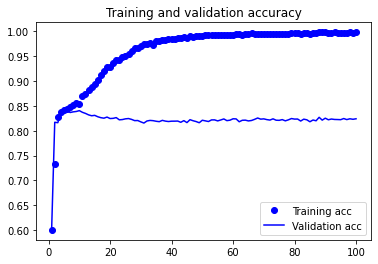

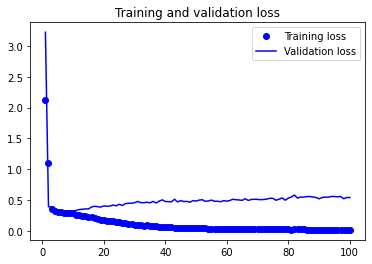

In [27]:
import matplotlib.pyplot as plt

epochs=range(1,len(history_train_acc)+1)

plt.plot(epochs,history_train_acc,'bo',label='Training acc')
plt.plot(epochs,history_val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,history_train_loss,'bo',label='Training loss')
plt.plot(epochs,history_val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
#最善のエポックにおけるモデルを読み込み
model=keras.models.load_model('center_classifier_best.h5')

In [29]:
pred_labels_val=model.predict(val_inputs)

In [30]:
pred_labels_plt=model.predict(val_inputs, batch_size=100)
pred_labels_plt=pred_labels_plt.tolist()

#print(pred_labels)
round_num=[]
for i in range(len(pred_labels_plt)):
    round_num.append(round(pred_labels_plt[i][0],2))
pred_labels_plt=round_num
#pred_labels

In [33]:
#分類結果を保存
#val
for i in range(val_num):
    #切り分け
    num_i=i*window_num
    save_labels=pred_labels_val[num_i:num_i+window_num]
    array_label=[]
    for label_k in  save_labels:
        array_label.append(label_k[0])
    save_label_i=np.array(array_label).reshape((window_width_num-2,window_height_num-2))
    df_save_label=pd.DataFrame(save_label_i)

    #保存
    file_name='val/val_pred_classified_'+str(i).zfill(6)
    save_dir=dir_pred_classified+'/'+file_name+'.csv'
    df_save_label.to_csv(save_dir,header=None,index=None)

In [34]:
#test
if test_num>0:

    pred_labels_test=model.predict(test_inputs)

    #分類結果を保存
    #test
    for i in range(test_num):
        #切り分け
        num_i=i*window_num
        save_labels=pred_labels_test[num_i:num_i+window_num]
        array_label=[]
        for label_k in  save_labels:
            array_label.append(label_k[0])
        save_label_i=np.array(array_label).reshape((window_width_num,window_width_num))
        df_save_label=pd.DataFrame(save_label_i)

        #保存
        file_name='test/test_pred_classified_'+str(i).zfill(6)
        save_dir=dir_pred_classified+'/'+file_name+'.csv'
        df_save_label.to_csv(save_dir,header=None,index=None)